# Omnipose Segmentation from ImageJ Macro converted image directories

This file is meant to aid in omnipose segmentation in a reproducible and streamlined way to help with automated image analysis especially early QC to adjust experimental and imaging parameters as needed to optimize S/N for the experiment. 

#### Import Necessary packages and Functions

In [1]:
# Imports for all chunks
import os
import shutil
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from pathlib import Path
import time


In [2]:
# omnipose setup and GPU
from cellpose_omni import models, core
import torch
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


2023-10-24 17:24:43,485 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


import os
import shutil
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader

# Mapping dictionary for renaming channels
channel_map = {'Phase': 'phase', 'eGFP': 'fish', 'dapi': 'dapi'}

# Root directory
root_dir = r'C:\Users\Nikon\Downloads\Omni\sandbox_2'  #this would be a directory where your biorep level folder is stored

# Navigate through directories to find OME.TIFF files and rename them
for biorep_dir in os.listdir(root_dir):
    biorep_path = os.path.join(root_dir, biorep_dir)
    if os.path.isdir(biorep_path):
        for date_strain_dir in os.listdir(biorep_path):
            date_strain_path = os.path.join(biorep_path, date_strain_dir)
            if os.path.isdir(date_strain_path):
                for sub_dir in os.listdir(date_strain_path):
                    sub_dir_path = os.path.join(date_strain_path, sub_dir)
                    if os.path.isdir(sub_dir_path):
                        for img_data_dir in os.listdir(sub_dir_path):
                            img_data_path = os.path.join(sub_dir_path, img_data_dir)
                            if os.path.isdir(img_data_path):
                                for file in os.listdir(img_data_path):
                                    if file.endswith('.ome.tiff') or file.endswith('.ome.tif'):
                                        file_path = os.path.join(img_data_path, file)
                                        
                                        # Read the OME.TIFF file to get channel names
                                        reader = OmeTiffReader(file_path)
                                        ome_metadata = reader.ome_metadata
                                        channel_names = [channel.name for channel in ome_metadata.images[0].pixels.channels]
                                        
                                        # Rename folders and files based on channel names
                                        for i, channel_name in enumerate(channel_names):
                                            # Map the original channel name to the new name using the channel_map dictionary
                                            mapped_name = channel_map.get(channel_name, channel_name)
                                            
                                            # Create the old and new folder names based on channel index
                                            old_folder_name = f"C{i+1}-MAX_sequence"
                                            new_folder_name = f"{mapped_name}-MAX_sequence"
                                            
                                            # Create the full path to the old and new folder names
                                            old_folder_path = os.path.join(img_data_path, old_folder_name)
                                            new_folder_path = os.path.join(img_data_path, new_folder_name)
                                            
                                            # If the old folder exists, rename it to the new folder name
                                            if os.path.exists(old_folder_path):
                                                shutil.move(old_folder_path, new_folder_path)
                                            
                                            # Rename individual single-page TIFF files inside the new folder
                                            for single_tiff in os.listdir(new_folder_path):
                                                # Check if the file starts with the old channel name
                                                if single_tiff.startswith(f"C{i+1}-MAX"):
                                                    # Create the full path to the old single-page TIFF file
                                                    old_single_tiff_path = os.path.join(new_folder_path, single_tiff)
                                                    
                                                    # Create the new single-page TIFF file name based on mapped channel name
                                                    new_single_tiff_name = single_tiff.replace(f"C{i+1}-MAX", f"{mapped_name}-MAX")
                                                    
                                                    # Create the full path to the new single-page TIFF file
                                                    new_single_tiff_path = os.path.join(new_folder_path, new_single_tiff_name)
                                                    
                                                    # Rename the old single-page TIFF file to the new name
                                                    shutil.move(old_single_tiff_path, new_single_tiff_path)
                                            
                                            # Create old and new multi-page TIFF file names based on channel index
                                            old_file_name = f"C{i+1}-MAX.tif"
                                            new_file_name = f"{mapped_name}-MAX.tif"
                                            
                                            # Create the full path to the old and new multi-page TIFF files
                                            old_file_path = os.path.join(img_data_path, old_file_name)
                                            new_file_path = os.path.join(img_data_path, new_file_name)
                                            
                                            # If the old multi-page TIFF file exists, rename it to the new name
                                            if os.path.exists(old_file_path):
                                                shutil.move(old_file_path, new_file_path)




## Running Omnipose for Segmentation

Here is the incorporation into the omnipose script

### Importing the images and QC to check images match expectations

### Collecting all the tiff files for omnipose


In [4]:
from skimage import io  # Importing the io module from skimage for image reading

# Initialize an empty list to store the full paths of all phase-MAX_sequence TIFF files.
# This list will include both newly renamed and previously renamed phase files.
all_phase_max_sequence_files = []

# Counter for total images
total_images = 0

# Counter for images with issues
issues_counter = 0

# Use os.walk to navigate through the directory tree rooted at root_dir.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames) for each directory it visits.
# dirpath is the path to the current directory, dirnames is a list of subdirectories in the current directory,
# and filenames is a list of filenames in the current directory.

# Loop through the directory structure
for root, dirs, files in os.walk(root_dir):
    for dir in dirs:
        if dir == "phase-MAX_sequence":
            phase_folder_path = os.path.join(root, dir)
            for file in os.listdir(phase_folder_path):
                if file.endswith(".tif"):
                    full_file_path = os.path.join(phase_folder_path, file)
                    all_phase_max_sequence_files.append(full_file_path)
                    
                    # Read the image into an array
                    img = io.imread(full_file_path)
                    
                    # Perform quality checks
                    shape = img.shape
                    dtype = img.dtype
                    min_val, max_val = img.min(), img.max()

                    # Increment the total_images counter
                    total_images += 1

                    #quality control checks here
                    if shape != (512, 512) or min_val < 3500 or max_val > 35000:
                        issues_counter += 1
                        print(f"Warning: Image at {full_file_path} has issues.")
                        print(f"  - Original image shape: {shape}")
                        print(f"  - Data type: {dtype}")
                        print(f"  - Data range: min {min_val}, max {max_val}")

print(f"\nTotal number of images processed: {total_images}")
if issues_counter:
    print(f"Number of images with issues: {issues_counter}")
else:
    print("No issues found in images.")


  - Original image shape: (512, 512)
  - Data type: uint16
  - Data range: min 20039, max 35621
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 13891
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 13416
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 13723
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 18734
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 18379
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 4421, max 13416
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 4499, max 14666
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 15181
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data range: min 0, max 14552
  - Original image shape: (524, 527)
  - Data type: uint16
  - Data ra

### Segmentation


In [4]:
from skimage.io import imread, imsave
from skimage import img_as_uint 
import numpy as np
from cellpose_omni import models, utils, io as cellpose_io
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import time
from tifffile import TiffFile, imwrite
import re

# Check for CUDA-enabled GPU availability
# Uncomment this block when you want to switch to GPU computation

import torch

# Check for GPU availability and set the gpu flag
if torch.cuda.is_available():
    gpu = True
    print("CUDA-enabled GPU found. Switching to GPU mode.")
else:
    gpu = False
    print("No CUDA-enabled GPU found. Running on CPU.")



CUDA-enabled GPU found. Switching to GPU mode.


In [6]:
# Record the start time
start_time = time.time()

# Define function to create subdirectories
def create_sub_dirs(sequence_folder):
    sub_dirs = ['masks', 'outlines']
    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(sequence_folder, sub_dir)
        if not os.path.exists(sub_dir_path):
            os.makedirs(sub_dir_path)

# Define Function for saving multi-page results
def create_output_dirs(output_folder):
    sub_dirs = ['cell_only', 'background_only']
    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(output_folder, sub_dir)
        if not os.path.exists(sub_dir_path):
            os.makedirs(sub_dir_path)

# Function to extract sequence numbers from filenames
def extract_sequence_number(filename):
    match = re.search(r'-(\d{4})\.tif', filename)
    if match:
        return int(match.group(1))
    else:
        return None


# Function for Extracting the Multipage Tiff within Directory     
def find_multipage_tiff(directory):
    current_dir = directory
    parent_dir = os.path.dirname(current_dir)
    all_files = os.listdir(os.path.dirname(current_dir))
    filtered_files = [f for f in all_files if "LZ222" in f and "ome" not in f]
    return os.path.join(parent_dir, filtered_files[0])

# Initialize model
model_name = 'bact_phase_omni'
model = models.CellposeModel(gpu=gpu, model_type=model_name)

# define parameters
params = {
    'channels': [0,0],  # Segment based on first channel, no second channel
    'rescale': None,  # upscale or downscale your images, None = no rescaling
    'mask_threshold': -1,  # erode or dilate masks with higher or lower values
    'flow_threshold': 0,  # default is .4, but only needed if there are spurious masks to clean up; slows down output
    'transparency': True,  # transparency in flow output
    'omni': True,  # we can turn off Omnipose mask reconstruction, not advised
    'cluster': True,  # use DBSCAN clustering
    'resample': True,  # whether or not to run dynamics on rescaled grid or original grid
    'verbose': False,  # turn on if you want to see more output
    'tile': False,  # average the outputs from flipped (augmented) images; slower, usually not needed
    'niter': None,  # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation
    'augment': False,  # Can optionally rotate the image and average outputs, usually not needed
    'affinity_seg': False,  # new feature, stay tuned...
}



## Segmentation and post-processing
for file in sorted(all_phase_max_sequence_files):  # Note the sorting, should be grabbing a file based on its name and reading that image file
    sequence_number = extract_sequence_number(os.path.basename(file))


    # Read the image
    image = imread(file)
    
    # Apply the model
    masks, flows, styles = model.eval(image, **params)
    
    # Generate cell-only and background-only images
    cell_only_image = image * (masks > 0)
    background_only_image = image * (masks == 0)
    
    label_image = label(masks)

    # Create subdirectories for saving within phase-max
    directory = os.path.dirname(file)
    create_sub_dirs(directory)
    filename = os.path.basename(file)
    base_name = os.path.splitext(filename)[0]

     # Find the corresponding multi-page TIFF
    tiff_path = find_multipage_tiff(os.path.dirname(file)) # * i dont know why this is grabbed here seems out of place 
    with TiffFile(tiff_path) as tif: 
        multi_page_tiff = tif.asarray() #read image into a numpy array

    # Initialize output folders
    output_folder_cell_only = os.path.join(os.path.dirname(tiff_path), 'cell_only')
    output_folder_bg_only = os.path.join(os.path.dirname(tiff_path), 'background_only')

    # Create output directories if they don't exist
    create_output_dirs(output_folder_cell_only)
    create_output_dirs(output_folder_bg_only)
    
    sequence_number = sequence_number -1

# Apply the mask to each channel in each sequence (here an XY frame) and Z-plane, just use the current mask 
    if sequence_number < multi_page_tiff.shape[0]: 
    
        for z in range(multi_page_tiff.shape[1]):
            for channel in range(multi_page_tiff.shape[2]):
                single_image = multi_page_tiff[sequence_number, z, channel, :, :]
                single_image_cells = single_image * (masks > 0)
                single_image_background = single_image * (masks == 0)
                        
                # Generate the output paths
                output_cell_only_path = os.path.join(output_folder_cell_only, f"frame_{sequence_number}_Z_{z}_Channel_{channel}.tif")
                output_bg_only_path = os.path.join(output_folder_bg_only, f"frame_{sequence_number}_Z_{z}_Channel_{channel}.tif")
                        
                # Save the cell-only and background-only images
                imwrite(output_cell_only_path, single_image_cells)
                imwrite(output_bg_only_path, single_image_background)
    else:
            print(f"Skipping {sequence_number} as it is out of bounds.")

    # Modify the output paths
    output_cell_only_path = os.path.join(directory, 'cell_only', f"{base_name}_cell_only.tif")
    output_background_only_path = os.path.join(directory, 'background_only', f"{base_name}_background_only.tif")
    output_outlines_path = os.path.join(directory, 'outlines', f"{base_name}_outlines.txt")
    output_mask_path = os.path.join(directory, 'masks', f"{base_name}_mask.tif")
    
    # Save the images and outlines
    cellpose_io.outlines_to_text(output_outlines_path, label_image)
    imwrite(output_mask_path, masks.astype(np.uint16))

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time for the code chunk: {elapsed_time:.2f} seconds")

2023-10-24 17:02:55,561 [INFO] >>bact_phase_omni<< model set to be used
2023-10-24 17:02:55,561 [INFO] ** TORCH GPU version installed and working. **
2023-10-24 17:02:55,561 [INFO] >>>> using GPU


Elapsed time for the code chunk: 222.13 seconds


## Statistical Analysis

Now that I have all of the images post mask processing in an organized format I can look into reading them into the memory and performing statistics on them. 


### Intializing Functions for Analysis and Metadata Assignments


In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import ast 
import re


# Function to calculate image statistics
def calculate_image_stats(image_path):
    # Read the image
    image = imread(image_path)

    # Check if the image is empty or all zeros
    if image.size == 0 or np.all(image == 0):
        print(f"Warning: The image at {image_path} is empty or all zeros.")
        return None  # Return None to indicate that stats could not be calculated
    
    
    # Filter out the zero pixels
    image = image[image > 0]
    # Initialize a dictionary to store the statistics
    stats_dict = {}
    # Calculate statistics
    stats_dict['mean'] = np.mean(image)
    stats_dict['median'] = np.median(image)
    stats_dict['max'] = np.max(image)
    stats_dict['min'] = np.min(image)
    stats_dict['std_dev'] = np.std(image)
    stats_dict['skewness'] = scipy.stats.skew(image)
    stats_dict['kurtosis'] = scipy.stats.kurtosis(image)
    stats_dict['pixel_count'] = len(image)
    stats_dict['area_covered'] = (len(image)/262144)
    # Extract easy Metadata

    # Extract metadata from the file path
    p = Path(image_path)

    ### From the deepest file level
    try:
        split_stem = p.stem.split('_')
        frame = split_stem[1]
        z_stack = split_stem[3]
        channel = split_stem[5]
        stats_dict['frame'] = frame
        stats_dict['z_stack'] = z_stack
        stats_dict['channel'] = channel
        stats_dict['full_filepath'] = str(p)  # Adding full file path
    except IndexError:
        print(f"Failed to extract frame, z_stack, channel from {p.stem}")

    ### From the directory structure
    root_parts = root.split('\\')
    try:
        condition = root_parts[9].split('_')[-1].split('.')[0]  # 'inf' or 'uninf'
        strain = root_parts[9].split('_')[1]  # 10min, 20min, etc.
        time = root_parts[9].split('_')[2].split('.')[0]  # LZ222##
        stats_dict['condition'] = condition
        stats_dict['time'] = time
        stats_dict['strain'] = strain
    except IndexError:
        print(f"Failed to extract condition, time, strain from {root}")

    # Extract 'image_type' from the directory name
    directory_name = os.path.dirname(image_path)  # Get the directory
    image_type = os.path.basename(directory_name)  # Extract the last part of the directory
    
    # Convert 'background_only' or 'cell_only' to 'background' or 'cell'
    if 'background_only' in image_type:
        image_type = 'background'
    elif 'cell_only' in image_type:
        image_type = 'cell'
    else:
        image_type = 'unknown'
    
    stats_dict['image_type'] = image_type

    biorep = '1'  # All 1 in this case
    stats_dict['biorep'] = biorep

    return stats_dict


# Function to extract metadata for channel naming
def extract_metadata_channel(root_dir):
    metadata_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.ome.tiff') or file.endswith('.ome.tif'):
                full_path = os.path.join(root, file)
                reader = OmeTiffReader(full_path)
                ome_metadata = reader.ome_metadata
                channel_names = [channel.name for channel in ome_metadata.images[0].pixels.channels]
                metadata_list.append({'full_filepath': full_path, 'channel_names': channel_names})
    return pd.DataFrame(metadata_list)

#import re  # Importing the regular expression library

def merge_metadata(df, df_metadata, channel_map=None):
    
    """
    Merge metadata into the main dataframe based on matching 'full_filepath'.
    A new column 'signal' is created based on the corresponding 'channel_names' from df_metadata.
    Optionally, a channel_map can be provided to rename the channels.
    
    Parameters:
    df (DataFrame): The main dataframe containing various columns including 'full_filepath' and 'channel'.
    df_metadata (DataFrame): Metadata dataframe containing 'full_filepath' and 'channel_names'.
    channel_map (dict, optional): A dictionary to map original channel names to new names.
    
    """
    # Initialize an empty list to hold the new 'signal' column values
    signal_list = [None] * len(df)
    
    # Loop through each row in df
    for i, row in df.iterrows():
        matched = False  # Variable to indicate if a match was found
        # Loop through each row in df_metadata
        for j, row_metadata in df_metadata.iterrows():
            # Separate the root from the filename using rsplit
            root_metadata = row_metadata['full_filepath'].rsplit('\\', 1)[0]
            
            # Create a regex pattern for the root
            pattern = re.compile(re.escape(root_metadata))
            
            # Use regex to find if the root exists in 'full_filepath' of df
            if pattern.search(row['full_filepath']):
                matched = True  # A match was found, set the variable to True
                # Check if the 'channel' value can be converted to an integer
                try:
                    channel_index = int(row['channel'])
                except ValueError:
                    print(f"Warning: Could not convert channel value {row['channel']} to integer at row {i}.")
                    continue  # Skip this row and continue with the next one

                # Check the type of channel_names and convert if necessary
                if isinstance(row_metadata['channel_names'], str):
                    try:
                        channel_names = ast.literal_eval(row_metadata['channel_names'])
                    except ValueError as e:
                        print(f"Failed to parse channel_names at row {j} in df_metadata: {e}")
                        continue
                else:
                    channel_names = row_metadata['channel_names']


                    # Check if channel_index is within the range of channel_names
                    if 0 <= channel_index < len(channel_names):
                        signal_name = channel_names[channel_index]
                        
                        # Apply channel_map if provided
                        if channel_map and signal_name in channel_map:
                            signal_name = channel_map[signal_name]
                        
                        signal_list[i] = signal_name
                    else:
                        print(f"Warning: channel_index {channel_index} is out of range for channel_names {channel_names} at row {i}.")
                    break  # No need to continue checking for this row, move on to the next one
                if not matched:
                    print(f"Warning: No metadata match found for row {i} with filepath {row['full_filepath']}.")
        # Add the new 'signal' column to df
        df['signal'] = signal_list




### Statistics and Metadata Assignment Calc

In [4]:


# Initialize an empty DataFrame to store the image statistics and metadata
df = pd.DataFrame()


# Directory path (Replace this with the actual path)
# root_dir = root_dir # this has been defined in the first chunk above, if need to redefine can do so here

# Iterate through directories and sub-directories
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".tif") and ('cell_only' in root or 'background_only' in root):
            file_path = os.path.join(root, file)
            stats = calculate_image_stats(file_path)
            
            if stats is not None:  # Only add to DataFrame if stats were successfully calculated
                df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)



In [9]:

# Extract metadata for channel naming
df_metadata = extract_metadata_channel(root_dir)

# Merge the metadata into the DataFrame
merge_metadata(df, df_metadata, channel_map = channel_map)

# Show the DataFrame (For demonstration, will only display the head)
print(df.head())


           mean   median    max   min     std_dev  skewness  kurtosis  \
0  10242.878421  10060.0  19183  6387  870.647995  2.313901  8.834251   
1   5763.509597   5732.0  15398  4049  470.939629  0.809239  4.273426   
2  10212.855300  10028.0  19272  6139  872.961733  2.334621  8.966507   
3   5452.585866   5430.0  13049  3663  435.475669  0.556898  2.232659   
4  10192.152762  10013.0  18489  5804  858.448014  2.260109  8.405057   

   pixel_count  area_covered frame z_stack channel  \
0       236793      0.903294     0       0       0   
1       236793      0.903294     0       0       1   
2       236793      0.903294     0       1       0   
3       236793      0.903294     0       1       1   
4       236793      0.903294     0       2       0   

                                       full_filepath condition   time  \
0  C:\Users\Nikon\Downloads\Omni\sandbox_2\biorep...     uninf  10min   
1  C:\Users\Nikon\Downloads\Omni\sandbox_2\biorep...     uninf  10min   
2  C:\Users\Nikon

In [10]:

# Specify the filename
filename = 'df.csv'

# Create the full path by joining root_dir and filename
full_path = os.path.join(root_dir, filename)

# Write the DataFrame to a CSV file
df.to_csv(full_path, index=False)


df_metadata.to_csv(r'C:\Users\Nikon\Downloads\Omni\sandbox_2\df_metadata.csv', index=False)


### Exploring the data from the images

##### Background-only EDA 

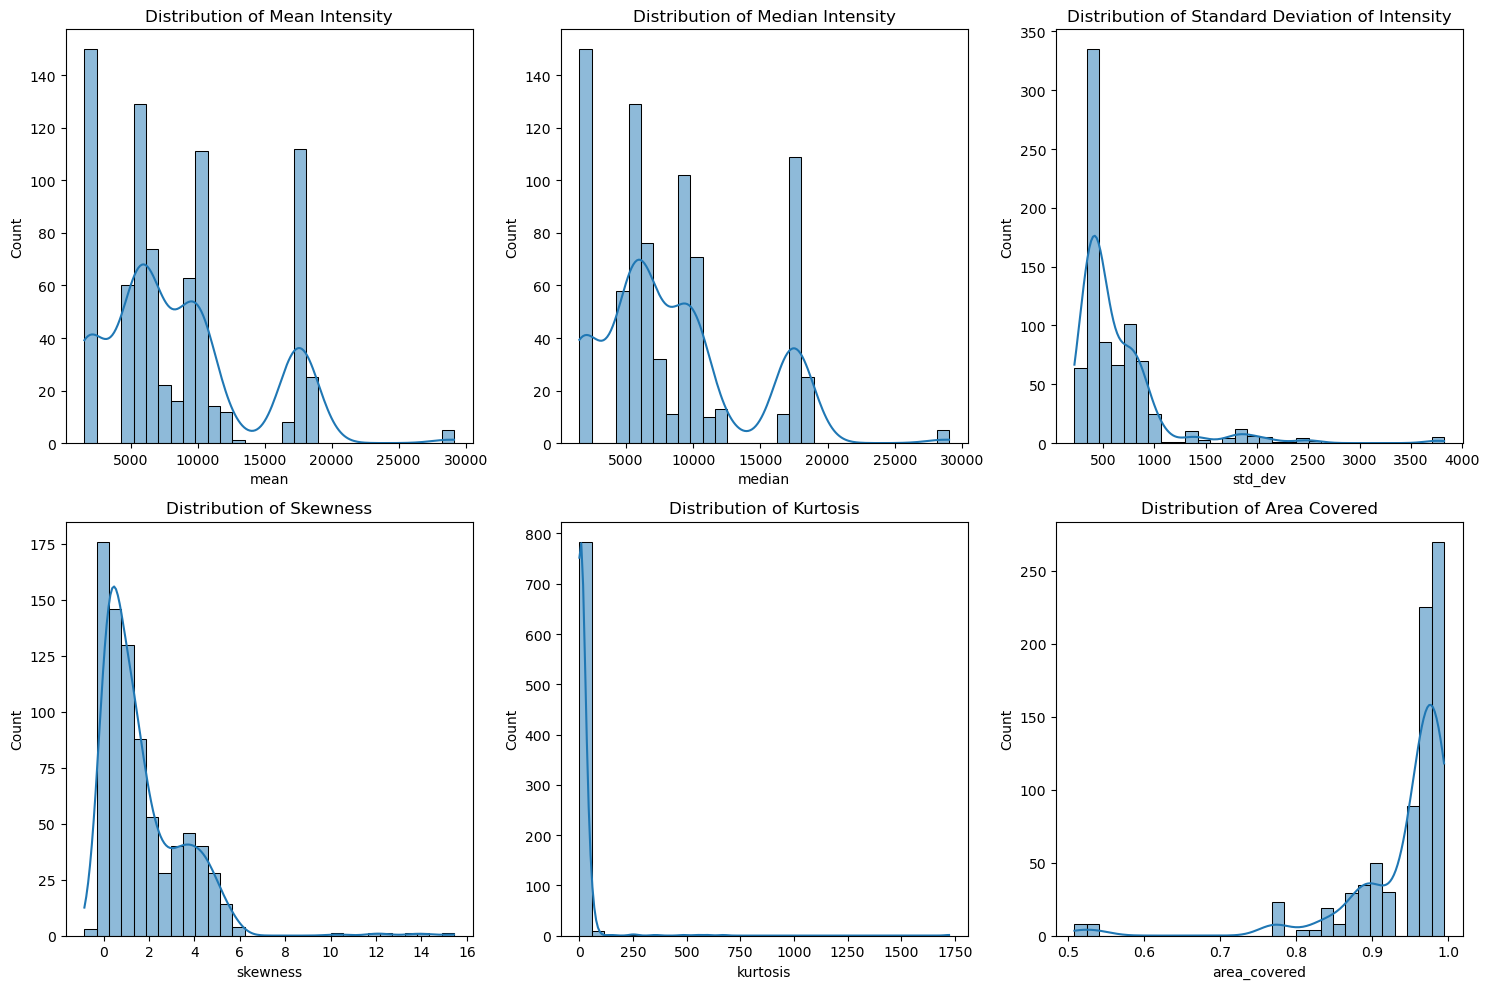

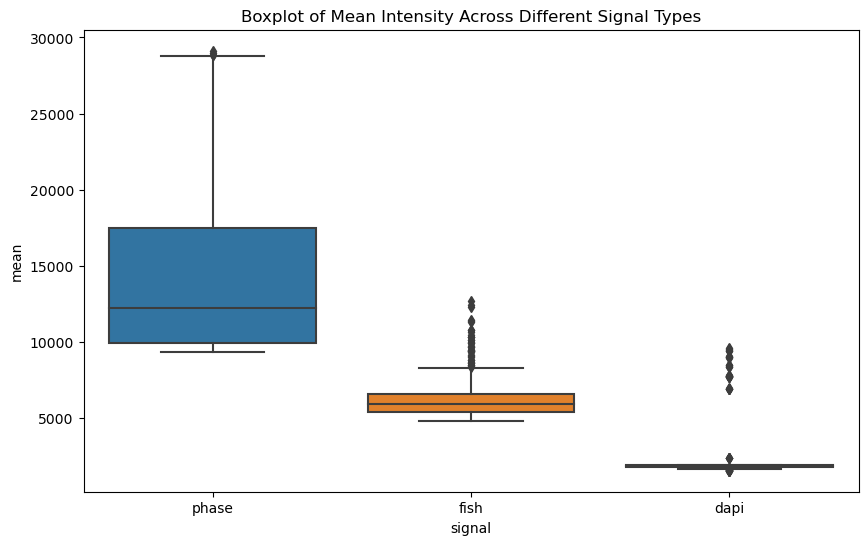

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\240939928.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_background_only.corr()


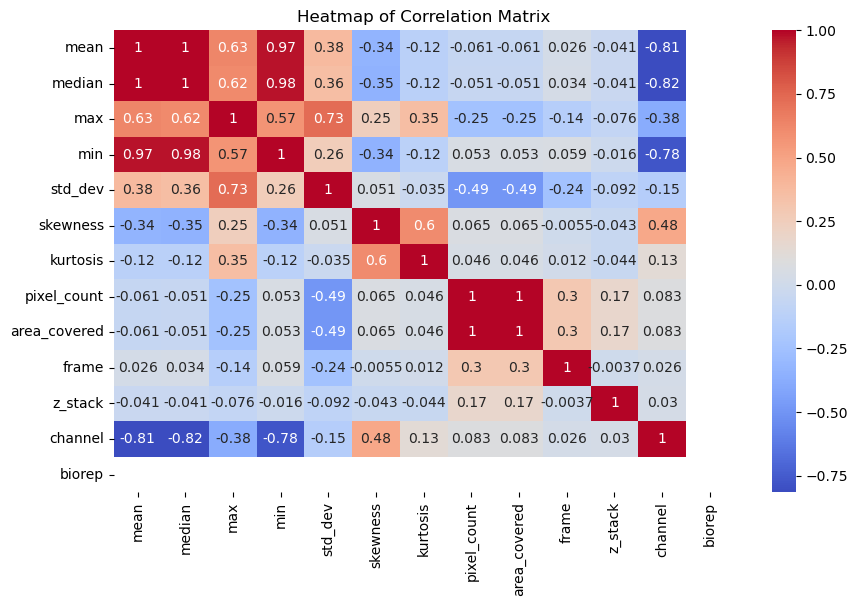

,mean,median,max,min,std_dev,skewness,kurtosis,pixel_count,area_covered,frame,z_stack,channel,biorep
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.0
mean,8512.255963,8429.722569,16083.125935,5958.047382,640.917550,1.688229,16.116069,246508.433915,0.940355,5.769327,1.902743,0.836658,1.0
std,5405.776388,5388.868433,9119.964067,4205.200902,450.394081,1.816253,75.853094,20503.957321,0.078216,4.304329,1.423196,0.765683,0.0
min,1552.652562,1532.000000,5626.000000,436.000000,222.069249,-0.843024,-0.371977,133160.000000,0.507965,0.000000,0.000000,0.000000,1.0
25%,5168.270937,5145.500000,8839.250000,3598.750000,394.528718,0.314481,0.851032,242106.000000,0.923561,2.000000,1.000000,0.000000,1.0
50%,6876.974104,6773.500000,13937.000000,4605.500000,463.181685,1.156371,3.872517,254121.000000,0.969395,5.000000,2.000000,1.000000,1.0
75%,10069.246483,10002.000000,22301.000000,7586.250000,777.529266,2.591587,12.804602,257344.000000,0.981689,9.000000,3.000000,1.000000,1.0
max,29129.721991,29039.000000,64946.000000,21681.000000,3823.350783,15.434161,1722.410869,260632.000000,0.994232,15.000000,4.000000,2.000000,1.0


In [15]:
import seaborn as sns

# Load the DataFrame from the CSV file
df = pd.read_csv(full_path)

# Filter the DataFrame to include only 'background only' images
df_background_only = df[df['image_type'] == 'background']

# Perform EDA on background-only DataFrame

# 1. Summary statistics
summary_stats = df_background_only.describe()

# 2. Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(df_background_only['mean'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Mean Intensity')
sns.histplot(df_background_only['median'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Median Intensity')
sns.histplot(df_background_only['std_dev'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Standard Deviation of Intensity')
sns.histplot(df_background_only['skewness'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Skewness')
sns.histplot(df_background_only['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Kurtosis')
sns.histplot(df_background_only['area_covered'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Area Covered')
plt.tight_layout()
plt.show()

# 3. Boxplots to examine the distribution of 'mean' across different 'signal' types
plt.figure(figsize=(10, 6))
sns.boxplot(x='signal', y='mean', data=df_background_only)
plt.title('Boxplot of Mean Intensity Across Different Signal Types')
plt.show()

# 4. Correlation matrix between numerical variables
correlation_matrix = df_background_only.corr()

# 5. Heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

summary_stats


### Separating Out the Different Channels

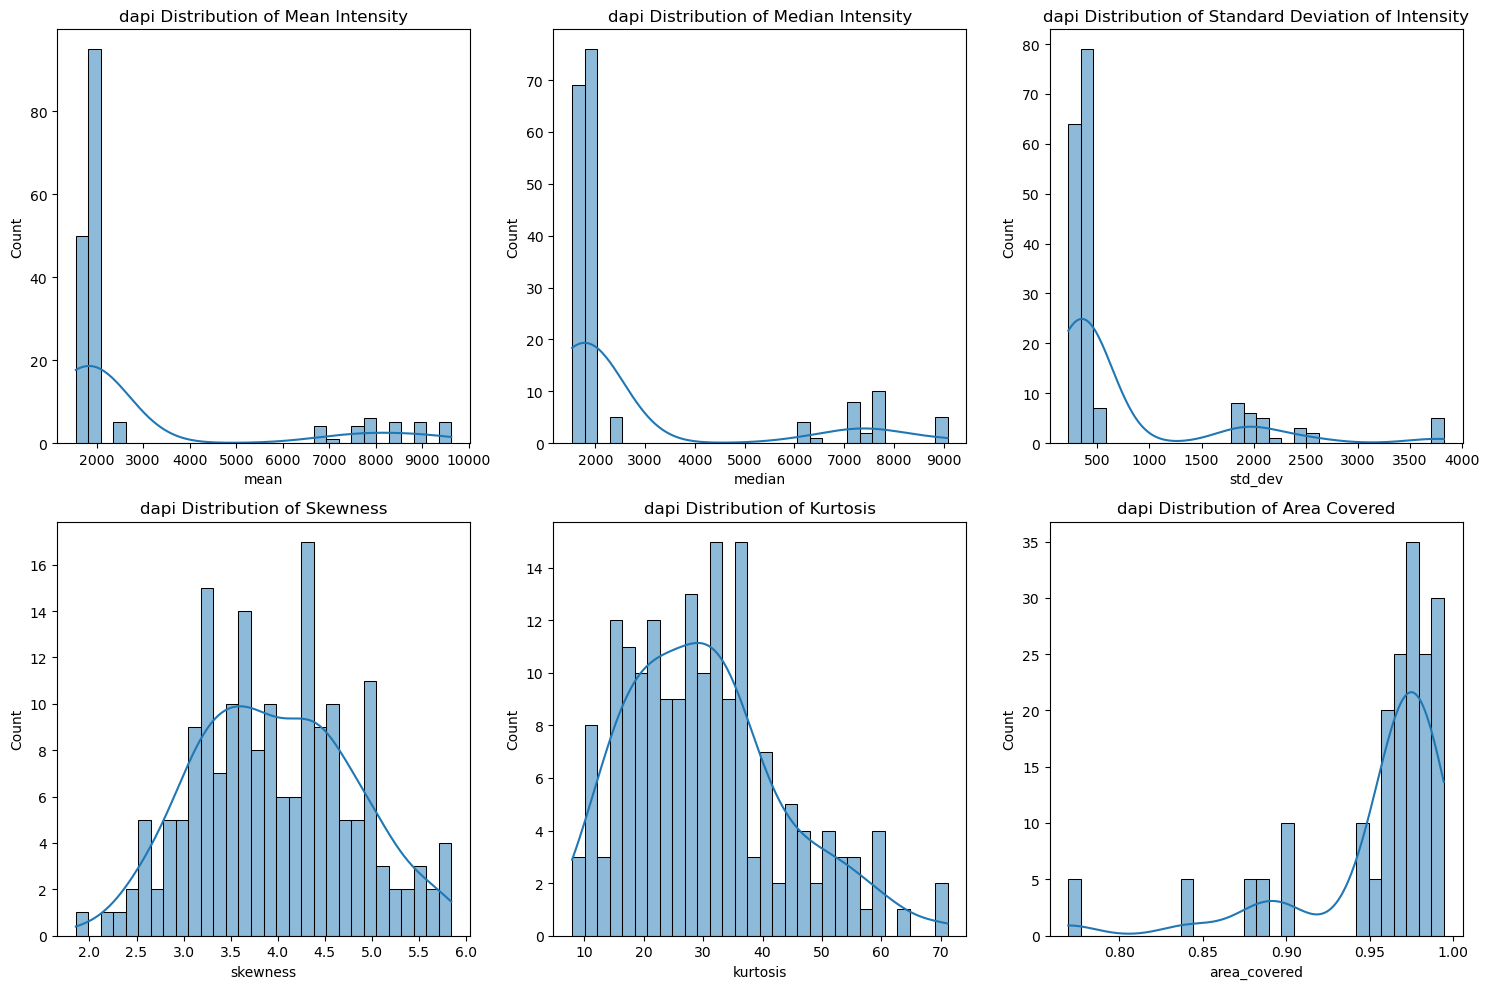

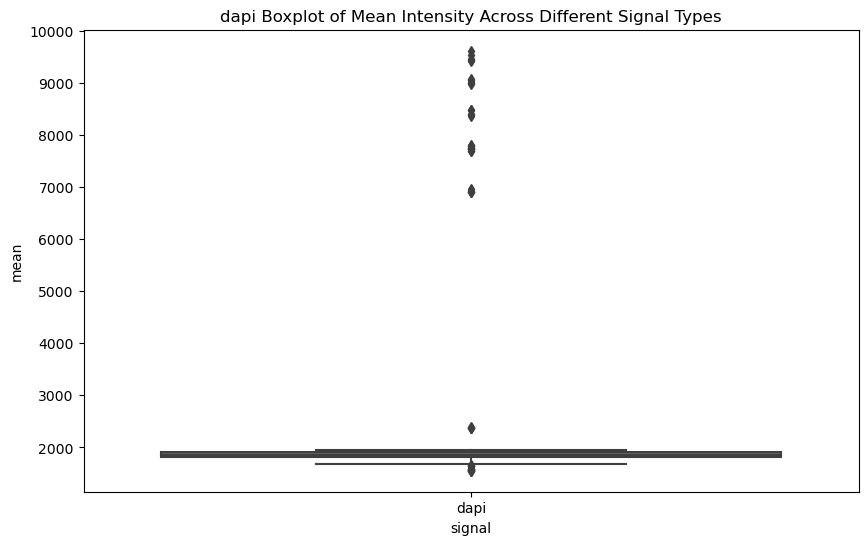

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\786460935.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


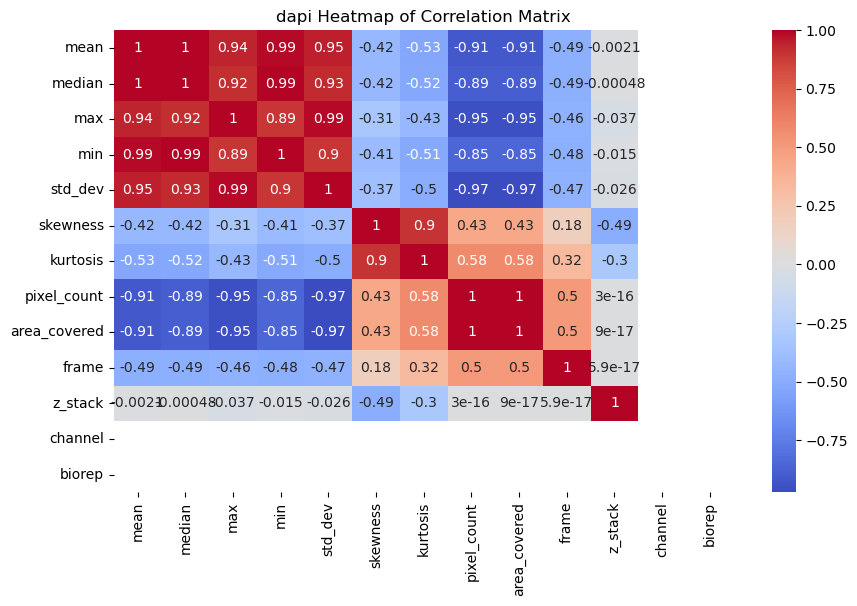

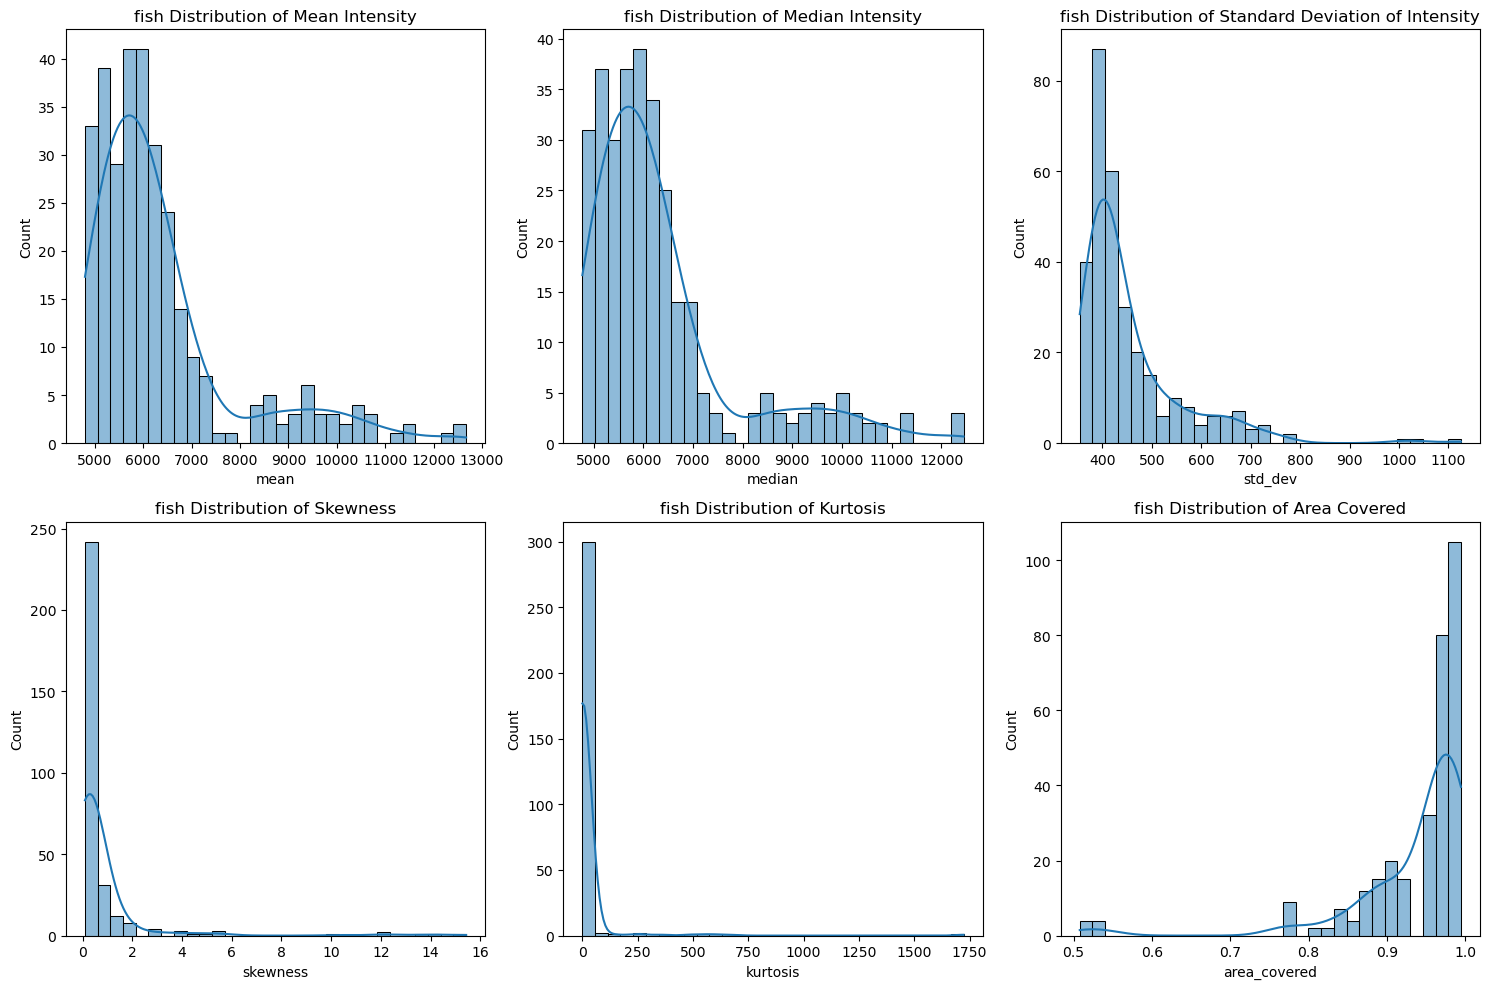

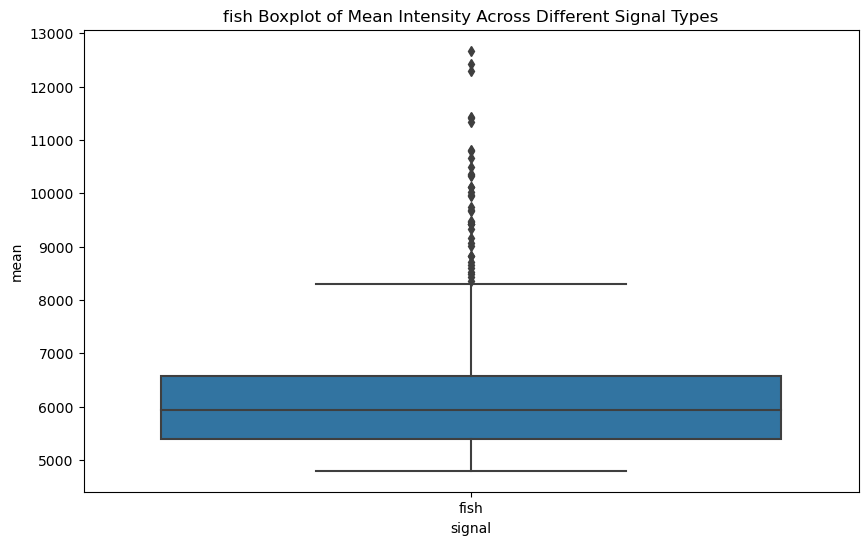

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\786460935.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


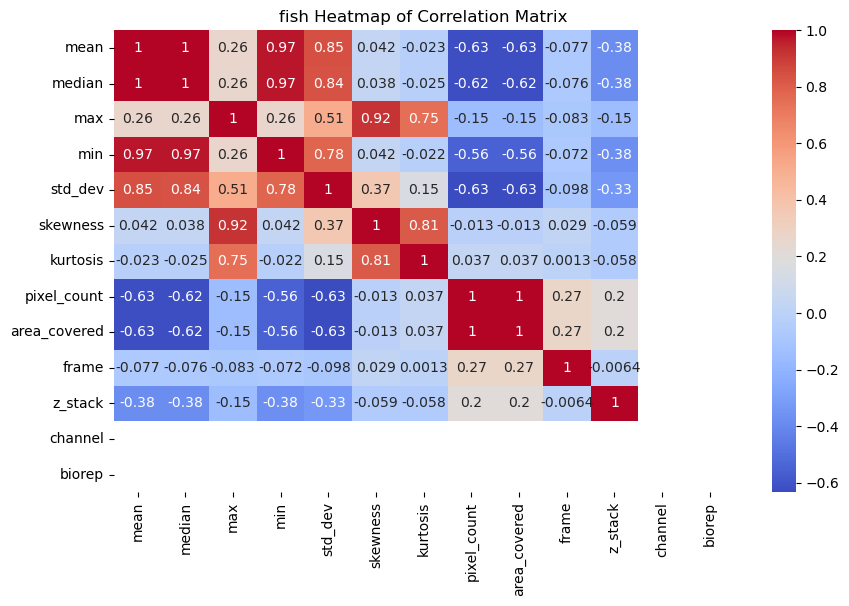

(              mean       median           max          min      std_dev  \
 count   180.000000   180.000000    180.000000   180.000000   180.000000   
 mean   2902.995932  2742.622222  13171.922222  1643.855556   683.270072   
 std    2417.217137  2172.011899  11512.806201  1416.652499   794.902989   
 min    1552.652562  1532.000000   5626.000000   436.000000   222.069249   
 25%    1815.509205  1770.750000   7606.750000   997.000000   311.670008   
 50%    1852.084842  1796.000000   8674.500000  1035.500000   368.999476   
 75%    1916.869504  1861.000000   9986.500000  1089.750000   427.792126   
 max    9620.549200  9077.000000  59189.000000  6360.000000  3823.350783   
 
          skewness    kurtosis    pixel_count  area_covered       frame  \
 count  180.000000  180.000000     180.000000    180.000000  180.000000   
 mean     3.968400   30.324337  250374.666667      0.955104    6.027778   
 std      0.827574   13.175064   12300.779784      0.046924    4.610445   
 min      1.85

In [16]:
# Filter the DataFrame to create two new DataFrames: df_dapi and df_fish
df_dapi = df_background_only[df_background_only['signal'] == 'dapi']
df_fish = df_background_only[df_background_only['signal'] == 'fish']

# Initialize a list to store the summary statistics for each DataFrame
summary_stats_list = []

# Function to perform EDA and return summary statistics
def perform_eda(df, title_prefix):
    # Summary statistics
    summary_stats = df.describe()
    summary_stats_list.append({f"{title_prefix} Summary Stats": summary_stats})
    
    # Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    sns.histplot(df['mean'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'{title_prefix} Distribution of Mean Intensity')
    sns.histplot(df['median'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'{title_prefix} Distribution of Median Intensity')
    sns.histplot(df['std_dev'], bins=30, kde=True, ax=axes[0, 2])
    axes[0, 2].set_title(f'{title_prefix} Distribution of Standard Deviation of Intensity')
    sns.histplot(df['skewness'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'{title_prefix} Distribution of Skewness')
    sns.histplot(df['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'{title_prefix} Distribution of Kurtosis')
    sns.histplot(df['area_covered'], bins=30, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title(f'{title_prefix} Distribution of Area Covered')
    plt.tight_layout()
    plt.show()
    
    # Boxplots to examine the distribution of 'mean' across different 'signal' types
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='signal', y='mean', data=df)
    plt.title(f'{title_prefix} Boxplot of Mean Intensity Across Different Signal Types')
    plt.show()
    
    # Correlation matrix between numerical variables
    correlation_matrix = df.corr()
    
    # Heatmap for the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'{title_prefix} Heatmap of Correlation Matrix')
    plt.show()
    
    return summary_stats

# Perform EDA on df_dapi and df_fish
summary_stats_dapi = perform_eda(df_dapi, "dapi")
summary_stats_fish = perform_eda(df_fish, "fish")

# Show summary statistics for dapi and fish
summary_stats_dapi, summary_stats_fish


### Observations and Interpretations

#### DAPI
1. **Mean Intensity**: The mean intensity for DAPI ranges from around 1553 to 9621 with a median value of approximately 1852. This suggests that DAPI staining varies across the images but is generally on the lower end of the intensity scale.
2. **Standard Deviation**: The standard deviation ranges from about 222 to 3823, indicating varied levels of heterogeneity in DAPI signal across the images.
3. **Skewness**: The distribution of skewness ranges from about 1.85 to 5.84, which indicates a positive skew (tail on the right-hand side) in the data distribution.
4. **Kurtosis**: The kurtosis ranges from about 7.91 to 71.16, suggesting that the distribution has heavy tails and is leptokurtic.

#### FISH
1. **Mean Intensity**: The mean intensity for FISH images ranges from around 4796 to 12673 with a median value of approximately 5939. This is considerably higher than DAPI, as expected.
2. **Standard Deviation**: The standard deviation ranges from about 354 to 1125, showing less variability in the FISH signals compared to DAPI.
3. **Skewness**: The skewness is relatively low, ranging from 0.088 to 15.43, suggesting that the FISH data is not as skewed as the DAPI data.
4. **Kurtosis**: The kurtosis for FISH is notably high, with a range from about 0.0006 to 1722.4. This indicates a leptokurtic distribution, similar to DAPI.

### Conclusions
- DAPI signals are generally lower in intensity but have a higher standard deviation, suggesting more variability in the signals.
- FISH signals are higher in intensity and are less variable compared to DAPI.
- Both DAPI and FISH show leptokurtic distributions, meaning they have heavy tails.
- The skewness in DAPI is notably higher, suggesting that the data is positively skewed.

Would you like to delve into any specific aspect further?

### Now Comparing with cells_only

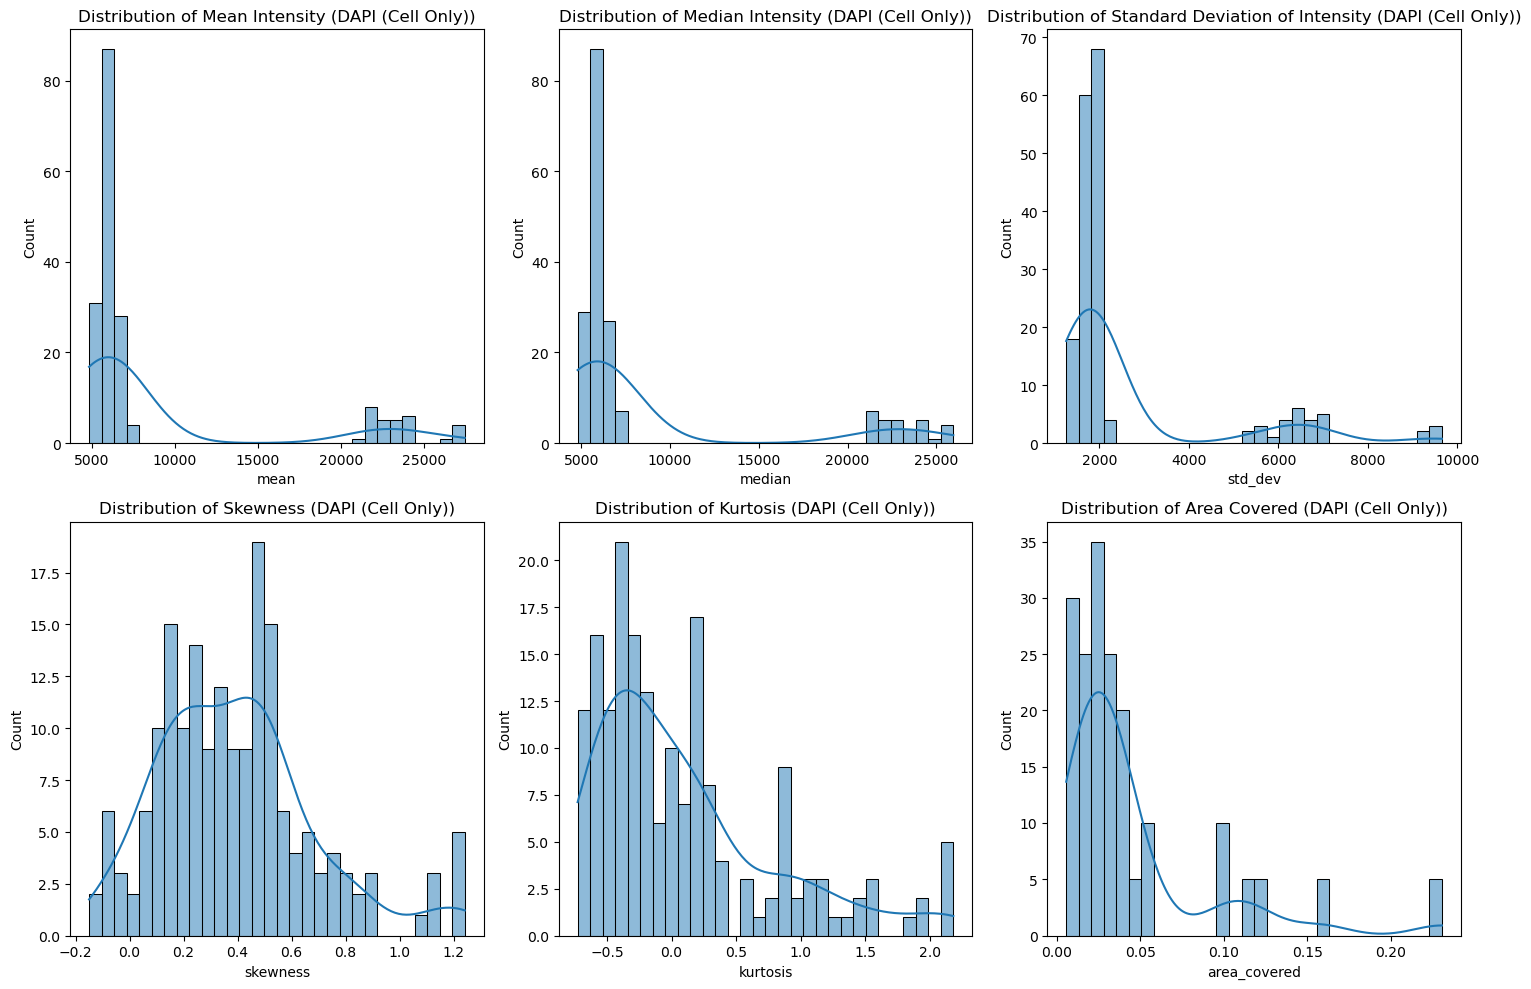

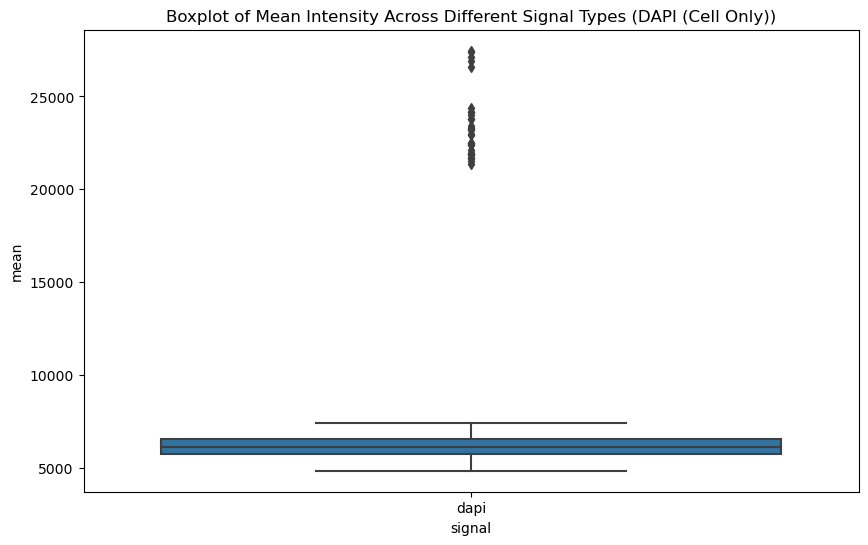

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\14765331.py:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


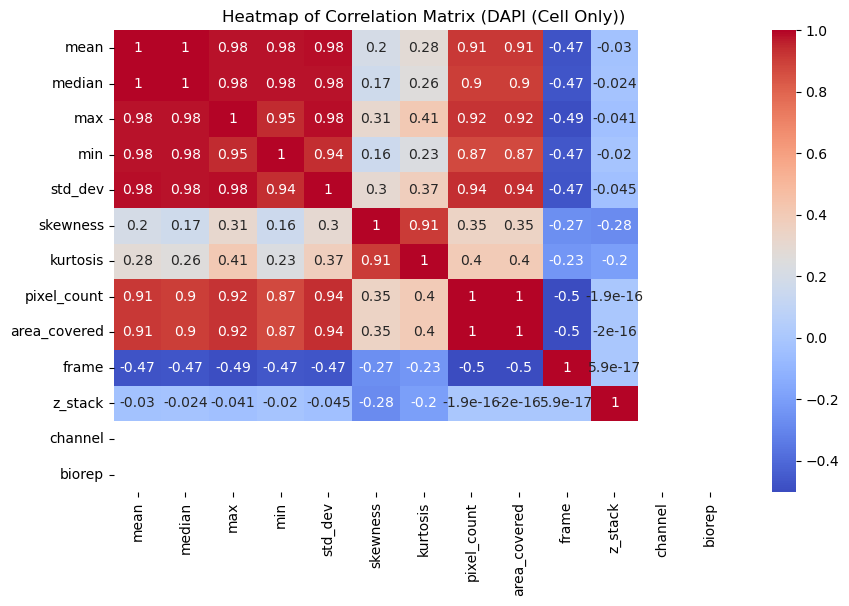

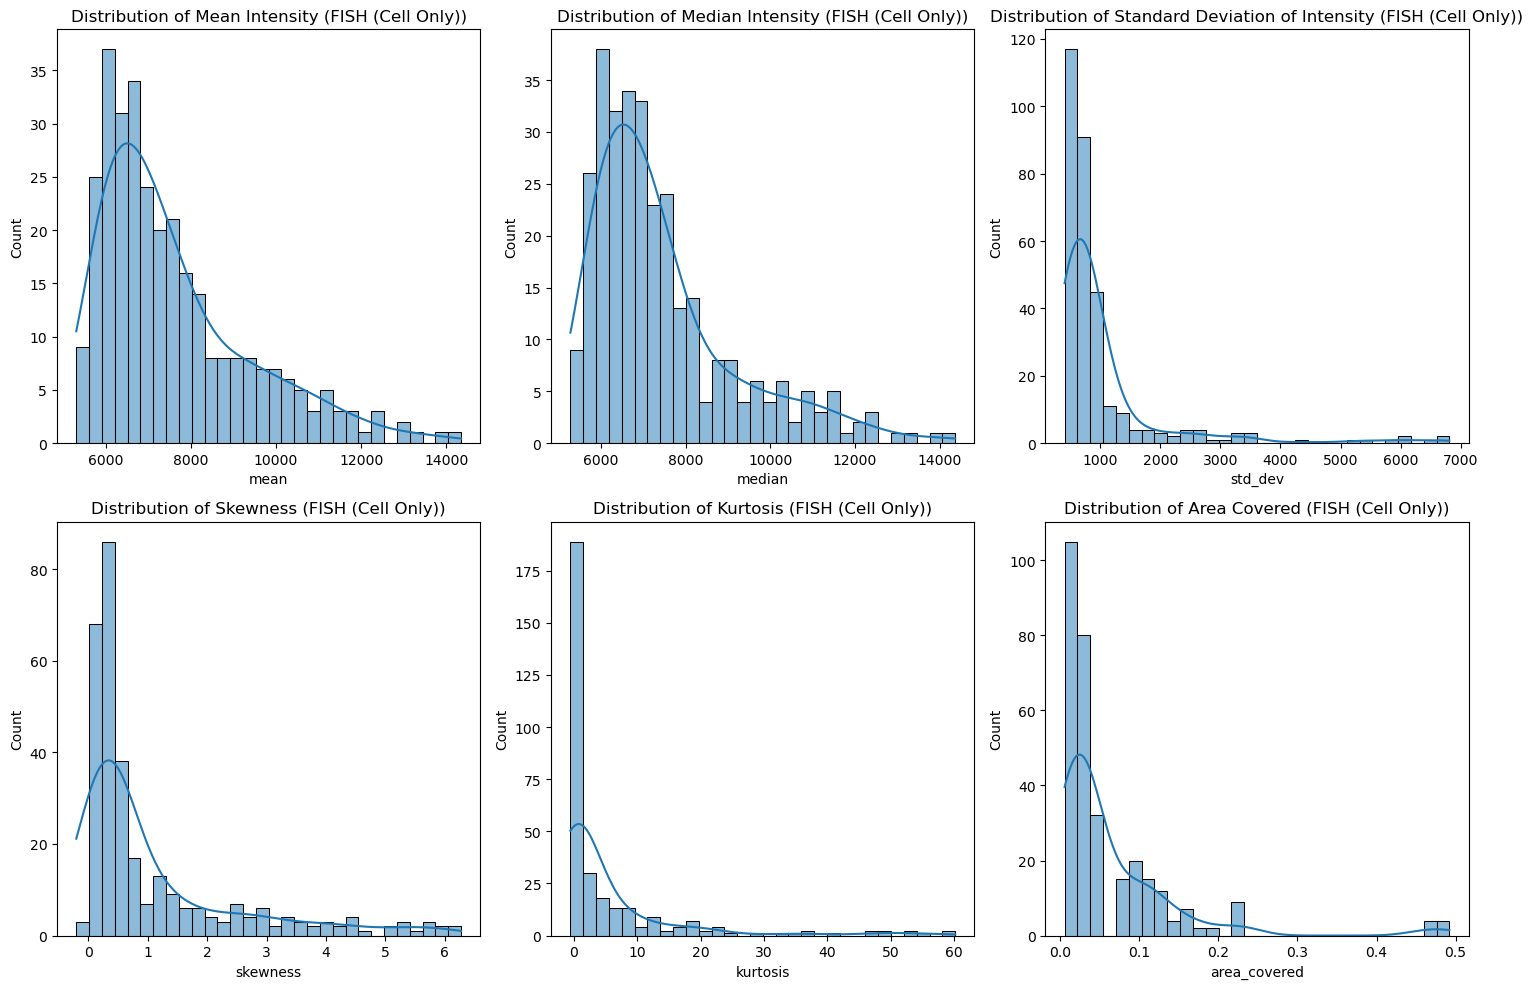

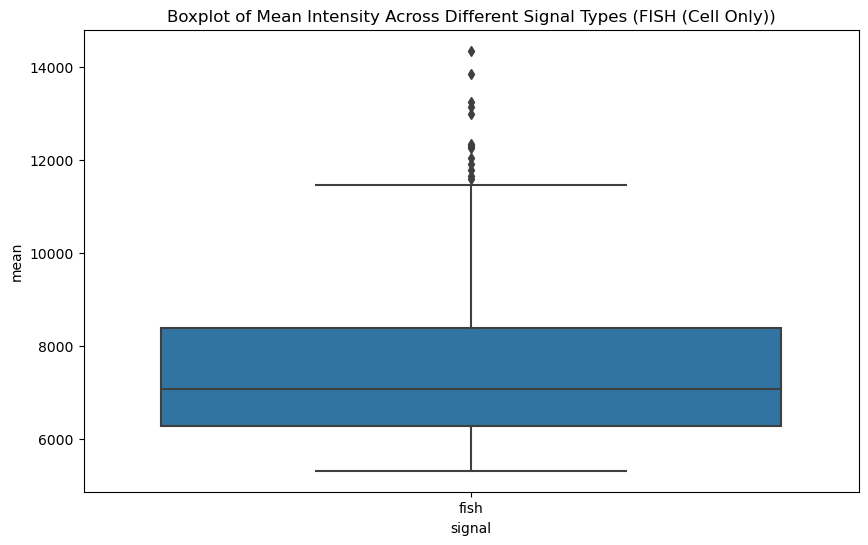

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\14765331.py:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


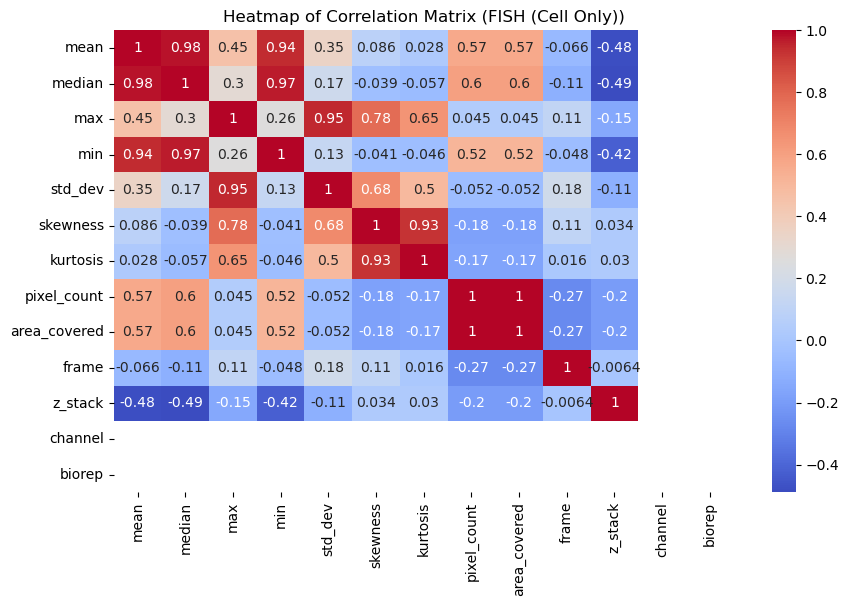

In [17]:
# Filter the DataFrame to include only 'cell_only' images
df_cell_only = df[df['image_type'] == 'cell']

# Prepare DataFrames for DAPI and FISH channels for 'cell_only' images
df_dapi_cell = df_cell_only[df_cell_only['signal'].str.lower() == 'dapi']
df_fish_cell = df_cell_only[df_cell_only['signal'].str.lower() == 'fish']

# Initialize a list to store summary statistics
summary_stats_cell = []

# Function to perform EDA and plot
def perform_eda(df, title_prefix):
    # Summary statistics
    summary_stats = df.describe()
    summary_stats_cell.append({f"{title_prefix}_stats": summary_stats})
    
    # Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    sns.histplot(df['mean'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Distribution of Mean Intensity ({title_prefix})')
    sns.histplot(df['median'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'Distribution of Median Intensity ({title_prefix})')
    sns.histplot(df['std_dev'], bins=30, kde=True, ax=axes[0, 2])
    axes[0, 2].set_title(f'Distribution of Standard Deviation of Intensity ({title_prefix})')
    sns.histplot(df['skewness'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Distribution of Skewness ({title_prefix})')
    sns.histplot(df['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Distribution of Kurtosis ({title_prefix})')
    sns.histplot(df['area_covered'], bins=30, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title(f'Distribution of Area Covered ({title_prefix})')
    plt.tight_layout()
    plt.show()

    # Boxplots to examine the distribution of 'mean' across different 'signal' types
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='signal', y='mean', data=df)
    plt.title(f'Boxplot of Mean Intensity Across Different Signal Types ({title_prefix})')
    plt.show()

    # Correlation matrix between numerical variables
    correlation_matrix = df.corr()

    # Heatmap for the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Heatmap of Correlation Matrix ({title_prefix})')
    plt.show()

# Perform EDA for DAPI in 'cell_only' images
perform_eda(df_dapi_cell, "DAPI (Cell Only)")

# Perform EDA for FISH in 'cell_only' images
perform_eda(df_fish_cell, "FISH (Cell Only)")


### Background Only vs Cell Only


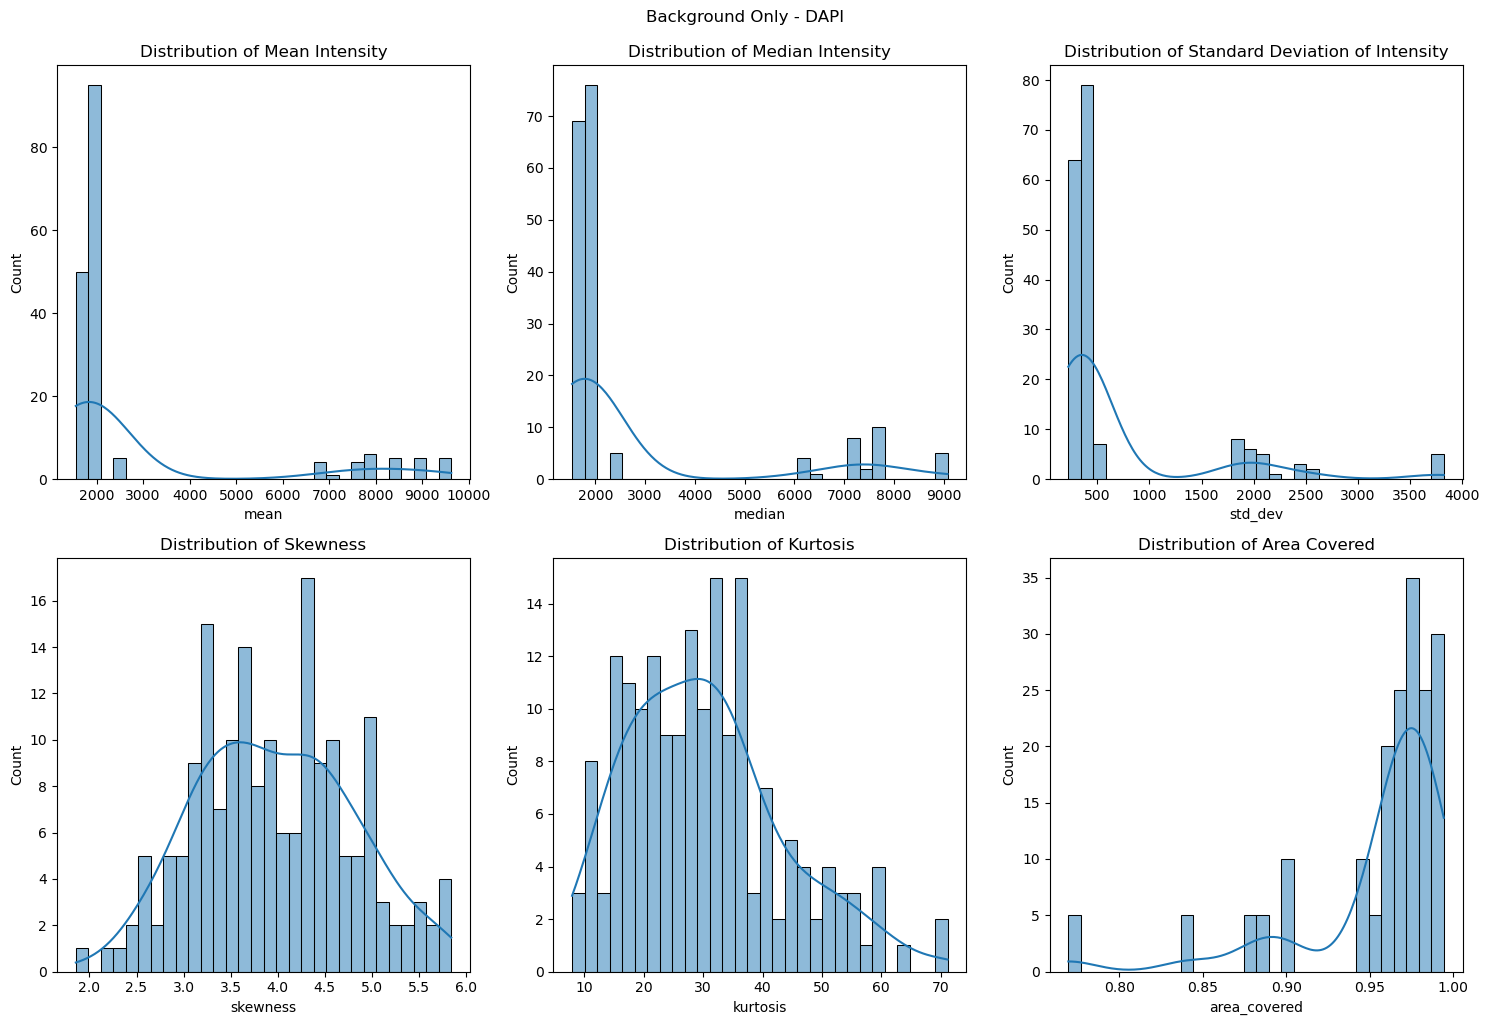

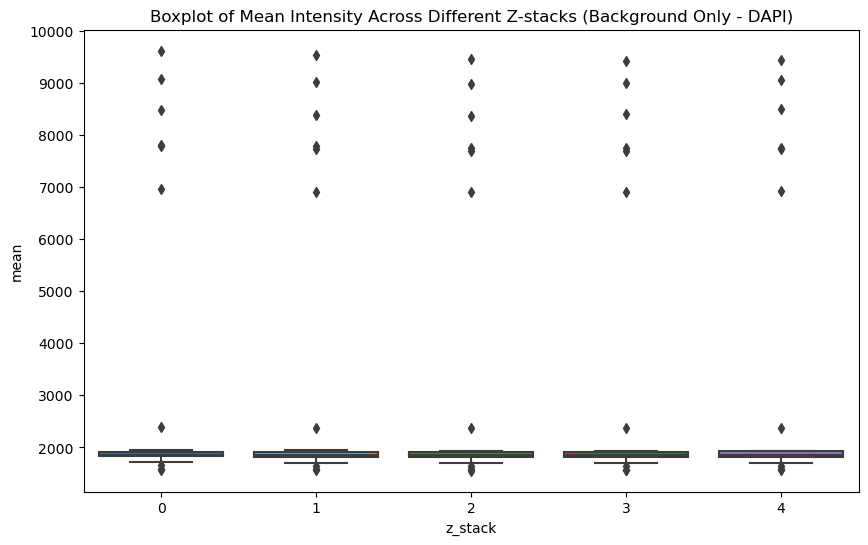

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\3469971833.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


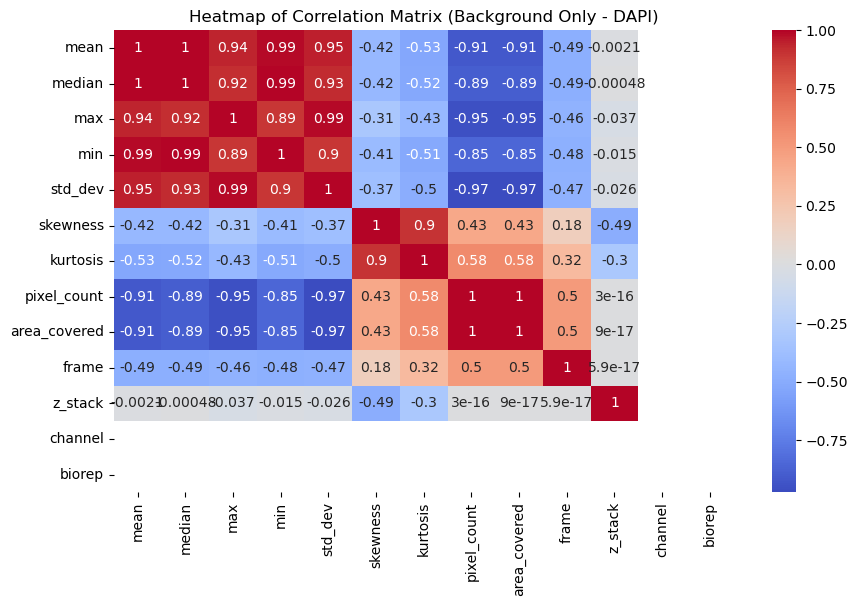

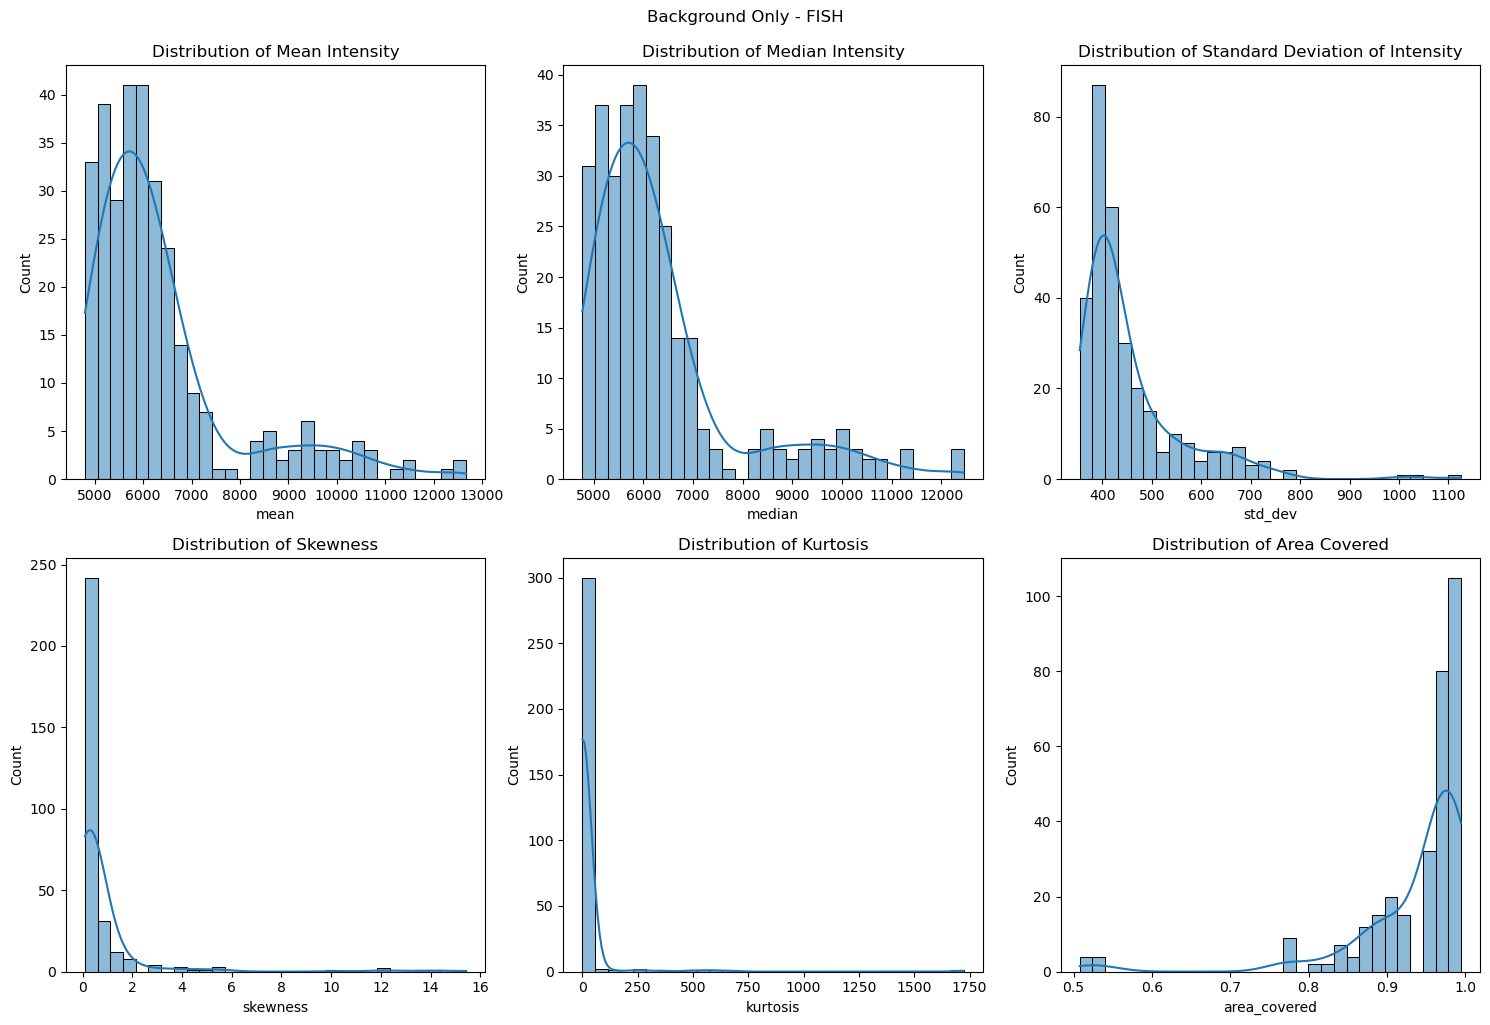

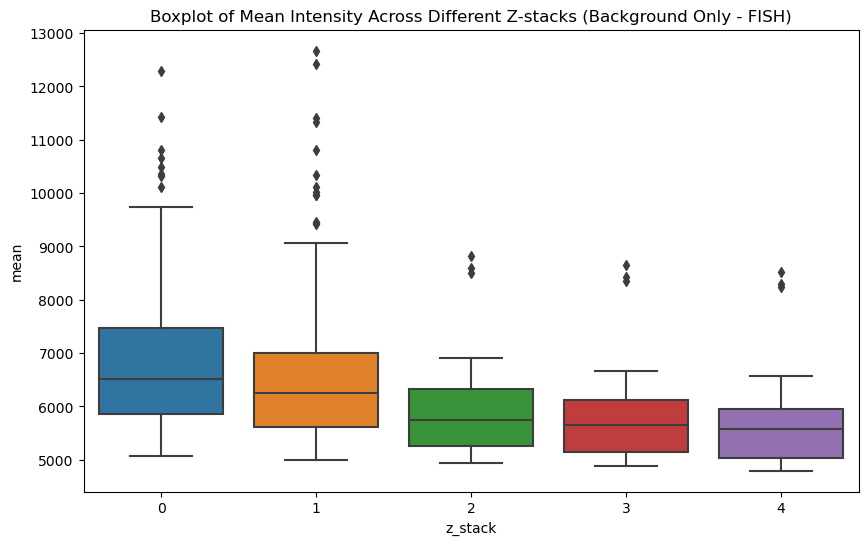

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\3469971833.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


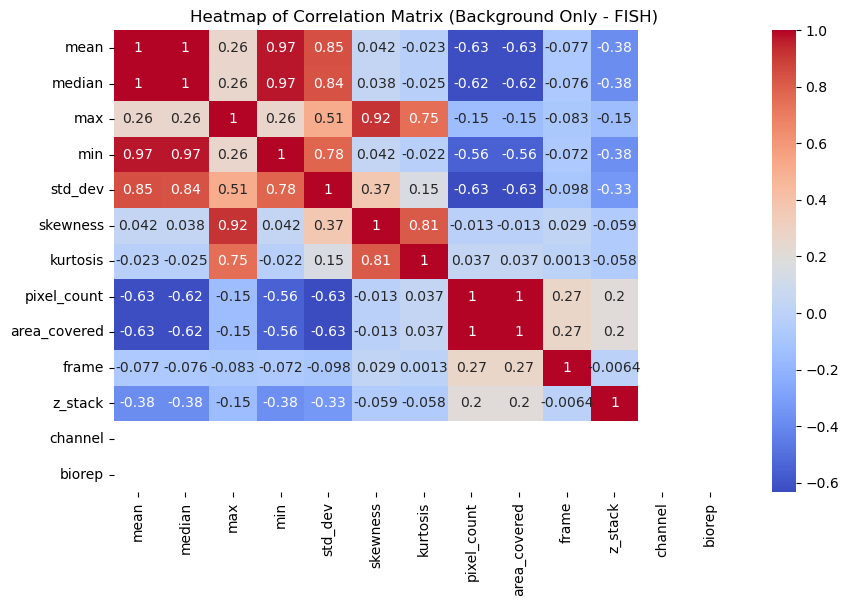

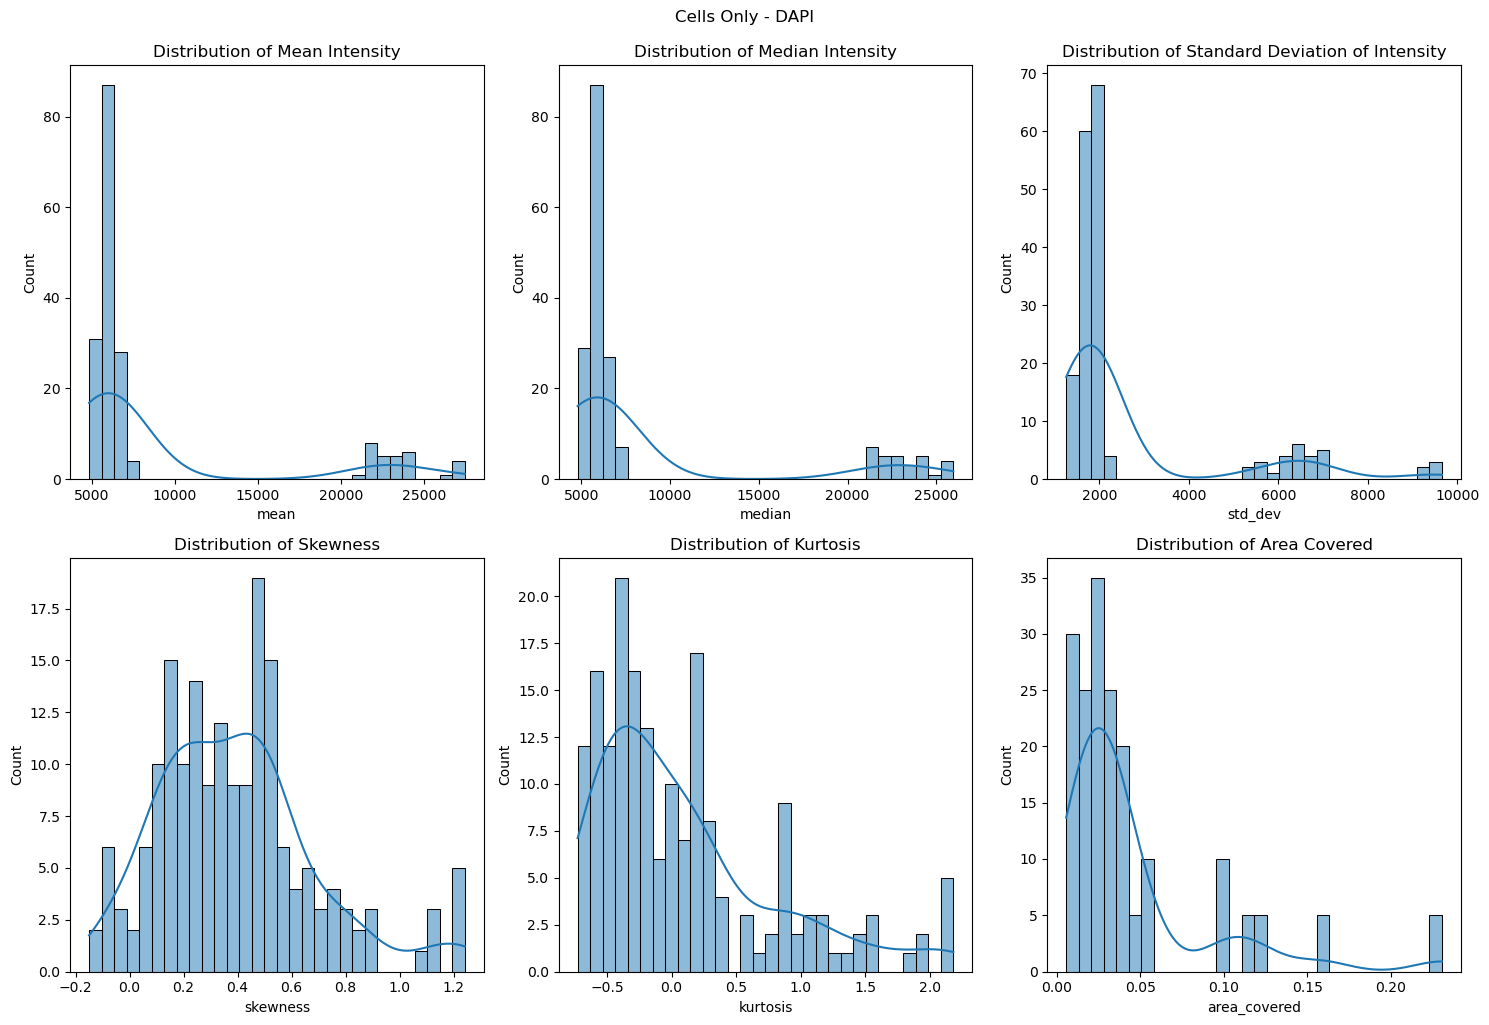

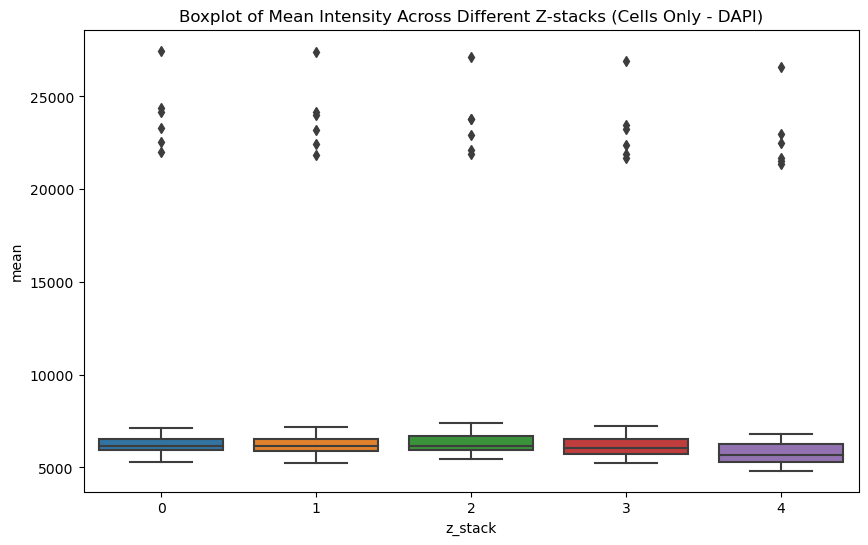

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\3469971833.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


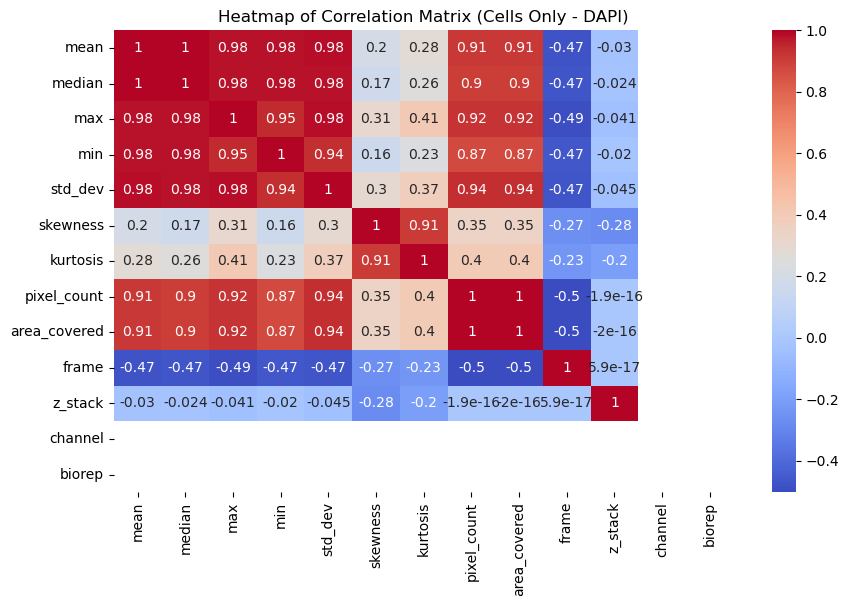

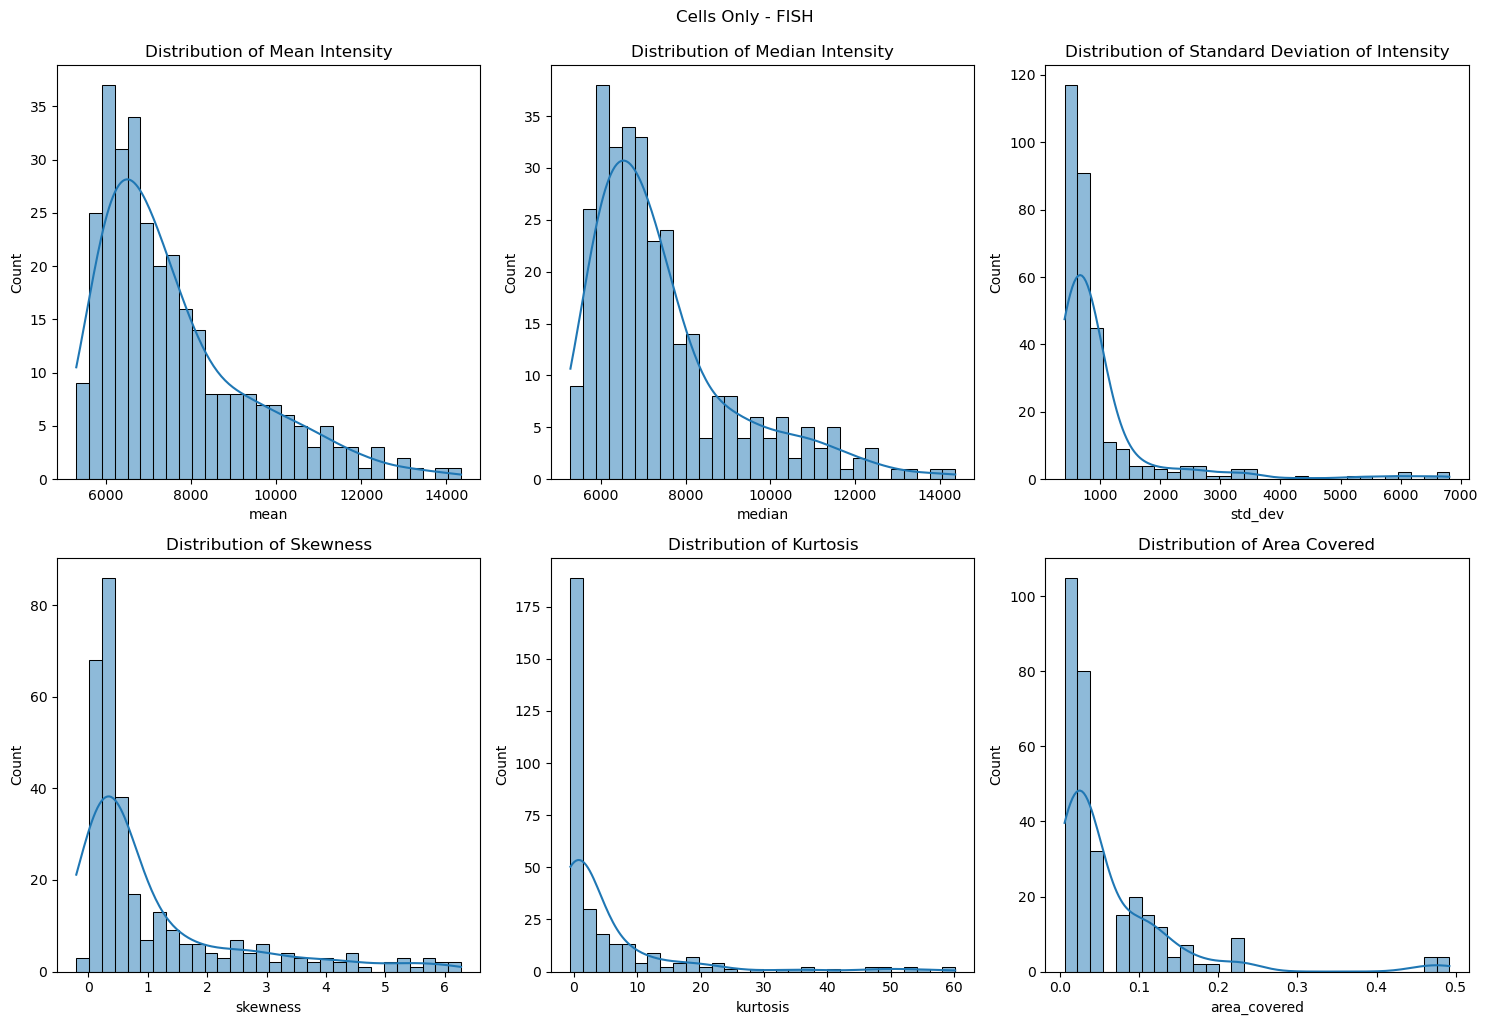

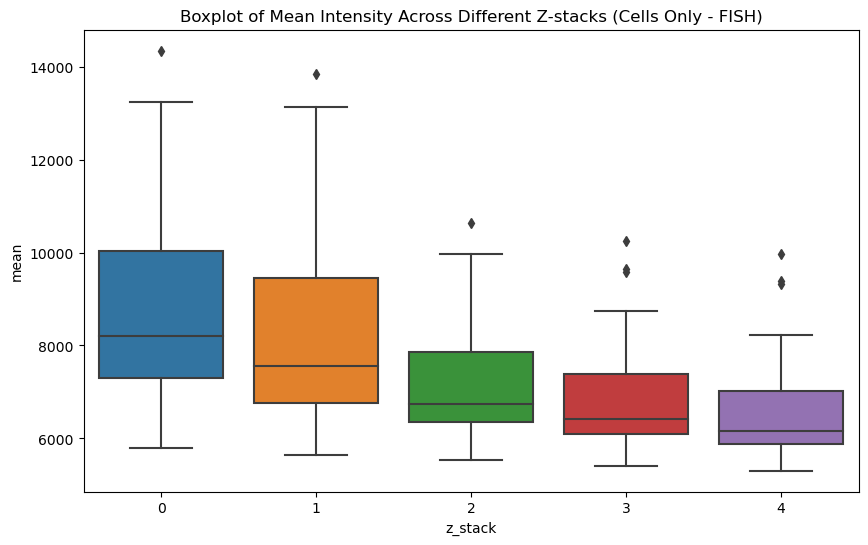

C:\Users\Nikon\AppData\Local\Temp\ipykernel_21564\3469971833.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


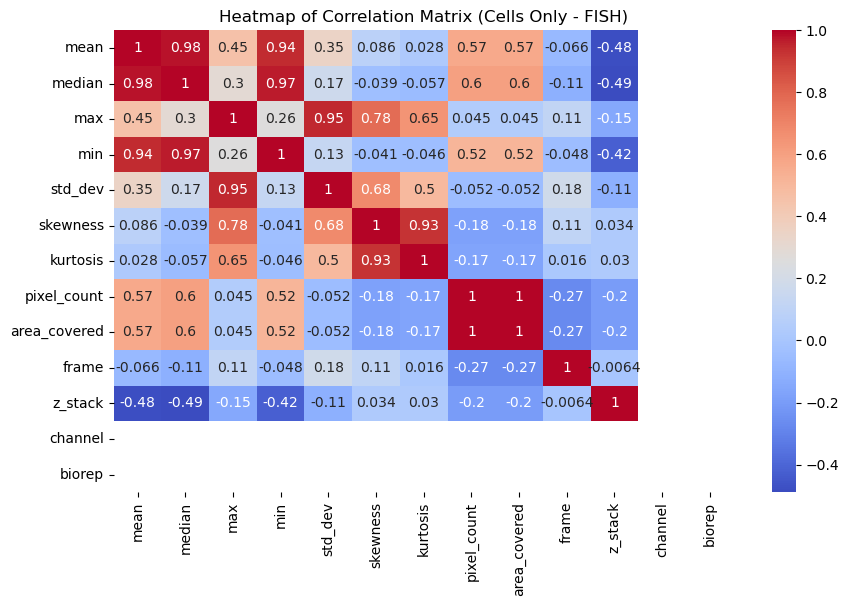

In [18]:
# Filter the DataFrame to include only 'background only' images and 'cell only' images for DAPI and FISH
df_background_dapi = df[(df['image_type'] == 'background') & (df['signal'] == 'dapi')]
df_background_fish = df[(df['image_type'] == 'background') & (df['signal'] == 'fish')]
df_cells_dapi = df[(df['image_type'] == 'cell') & (df['signal'] == 'dapi')]
df_cells_fish = df[(df['image_type'] == 'cell') & (df['signal'] == 'fish')]

# Function to perform the EDA
def perform_eda(df, title):
    # Summary statistics
    summary_stats = df.describe()
    
    # Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    sns.histplot(df['mean'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Mean Intensity')
    sns.histplot(df['median'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Median Intensity')
    sns.histplot(df['std_dev'], bins=30, kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('Distribution of Standard Deviation of Intensity')
    sns.histplot(df['skewness'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Skewness')
    sns.histplot(df['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Kurtosis')
    sns.histplot(df['area_covered'], bins=30, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title('Distribution of Area Covered')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()
    
    # Boxplots to examine the distribution of 'mean' across different 'z_stack'
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='z_stack', y='mean', data=df)
    plt.title(f'Boxplot of Mean Intensity Across Different Z-stacks ({title})')
    plt.show()
    
    # Correlation matrix between numerical variables
    correlation_matrix = df.corr()
    
    # Heatmap for the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Heatmap of Correlation Matrix ({title})')
    plt.show()
    
    return summary_stats

# Perform EDA on each of the subsets
summary_stats_background_dapi = perform_eda(df_background_dapi, 'Background Only - DAPI')
summary_stats_background_fish = perform_eda(df_background_fish, 'Background Only - FISH')
summary_stats_cells_dapi = perform_eda(df_cells_dapi, 'Cells Only - DAPI')
summary_stats_cells_fish = perform_eda(df_cells_fish, 'Cells Only - FISH')




c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


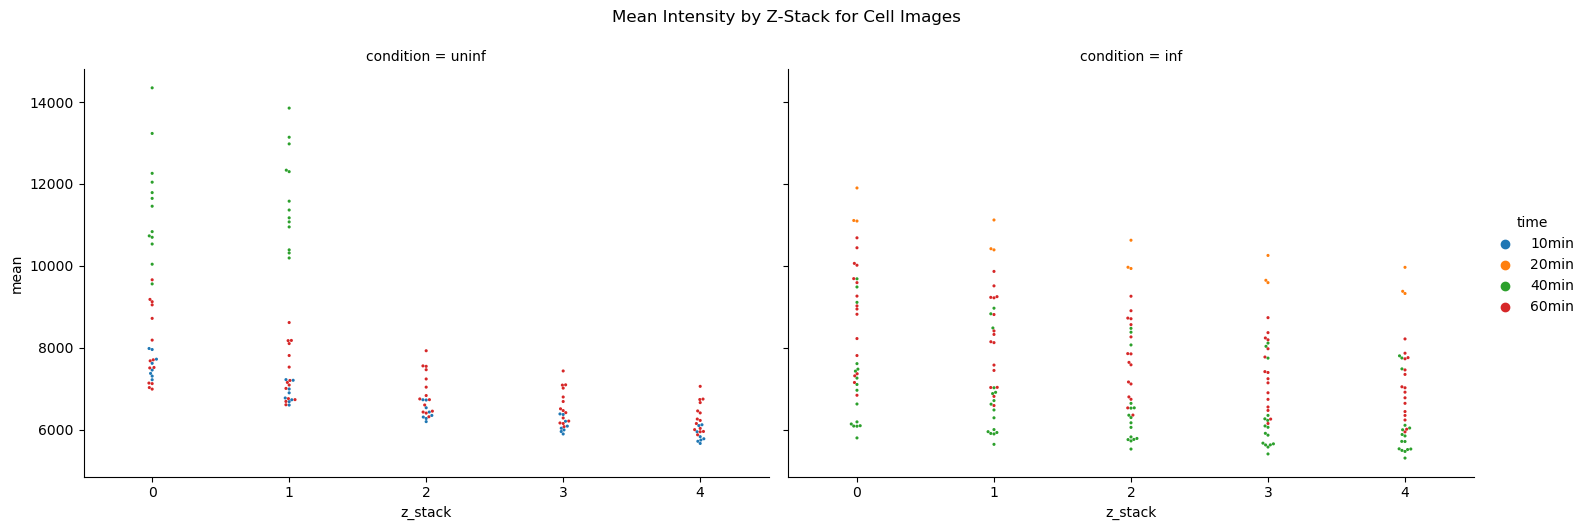

In [25]:
# Filter the DataFrame to include only 'cell' images
df_cell_only_fish = df[(df['image_type'] == 'cell') & (df['signal'] == 'fish')]

# Create the catplot for mean intensity across different Z-stacks, colored by time, and faceted by condition
sns.catplot(
    data=df_cell_only_fish, kind="swarm",
    x="z_stack", y="mean", hue="time", col="condition",
    aspect=1.5, s=5
)
plt.suptitle('Mean Intensity by Z-Stack for Cell Images', y=1.05)
plt.show()

In [ ]:
# Combining violin and swarm plots into the same plotting area
sns.catplot(
    data=df_cell_only_fish, kind="violin",
    x="z_stack", y="mean", hue="time", col="condition",
    aspect=.7, inner=None, palette="gray"
)
sns.catplot(
    data=df_cell_only_fish, kind="swarm",
    x="z_stack", y="mean", hue="time", col="condition",
    aspect=.7, dodge=True
)
plt.show()


In [21]:
# Filter the DataFrame to include only 'cell_only' images and 'fish' signal
df_cell_only_fish = df[(df['image_type'] == 'cell_only') & (df['signal'].str.lower() == 'fish')]

# Check the number of rows in the filtered DataFrame
df_cell_only_fish

,mean,median,max,min,std_dev,skewness,kurtosis,pixel_count,area_covered,frame,z_stack,channel,full_filepath,condition,time,strain,image_type,biorep,signal


# Need to redo below sections

#### Analyzing any possible effect on bleaching

The table provides the aggregated statistics of the 'mean' and 'std_dev' (standard deviation) of pixel intensities in the background-only images, grouped by different Z-stacks (from Z0 to Z5).

### Observations:

1. **Mean Pixel Intensity**: 
    - There is a slight decrease in the mean pixel intensity as we move from Z0 to Z5.
    - The mean intensity at Z0 is approximately 8825, and it decreases to around 8258 at Z5.
    
2. **Standard Deviation of Pixel Intensity**:
    - Interestingly, the standard deviation also decreases as we go deeper into the Z-stack.
    - At Z0, the mean standard deviation is around 693, which drops to approximately 593 at Z5.
    
3. **Variability**: 
    - The standard deviation of these metrics across different images also varies. For example, the standard deviation of the mean intensity at Z0 is approximately 5177, which suggests there's considerable variability in mean pixel intensity at this level.

### Interpretation:

1. The decrease in both mean intensity and standard deviation across Z-stacks could support our hypothesis that there might be bleaching or a decrease in signal as we go deeper into the Z-stacks but it doesnt seem to be any large difference. Hard to tell without internal average pizel intensities.
   
2. Given the standard deviations, it appears that the variability within each Z-stack is also decreasing as we go deeper into the Z-stack. This could indicate that the images at deeper Z-levels are more consistent in terms of pixel intensities, but also potentially less bright.

### Next Steps: VIsualizing


c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\categorical.py:299: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\categorical.py:299: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)


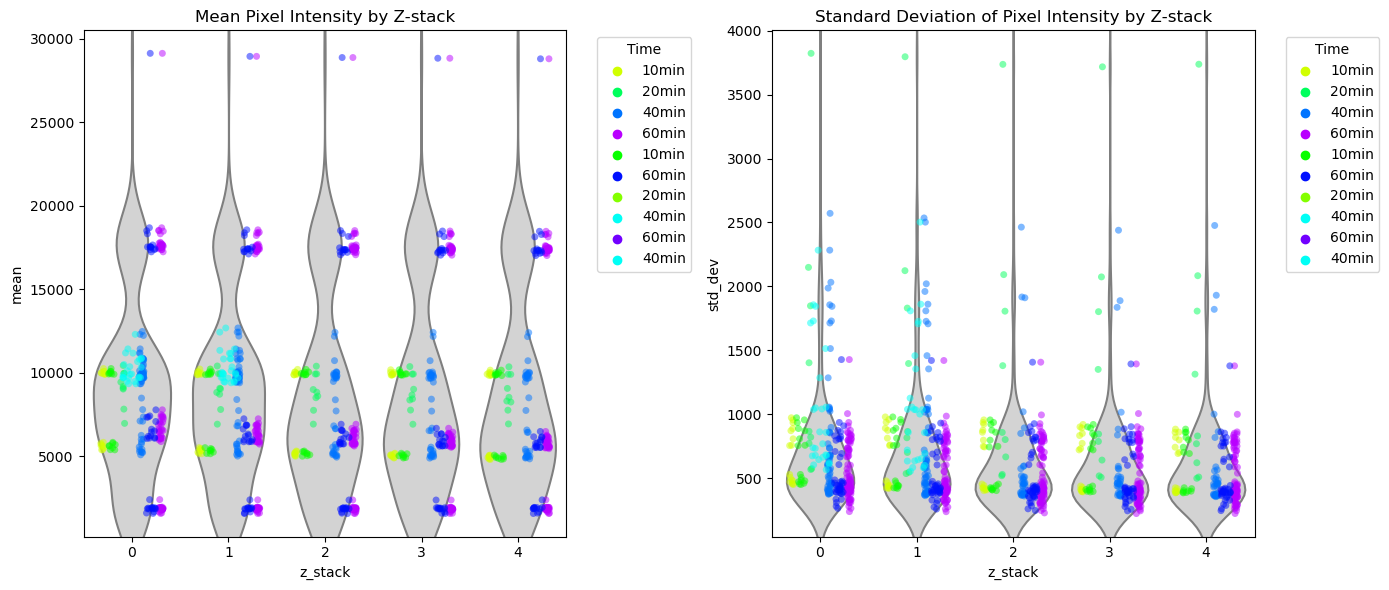

In [14]:
#### Violin Plots Labeled by condition and time groupings 

# Plotting the violin plots with individual data points colored by 'time' and marker style based on 'condition'
plt.figure(figsize=(14, 6))

# Plot for mean
plt.subplot(1, 2, 1)
sns.violinplot(x='z_stack', y='mean', data=df_background_only, inner=None, color='lightgray')
sns.stripplot(x='z_stack', y='mean', data=df_background_only, hue='time', dodge=True,
              marker='o', alpha=0.5, edgecolor='gray',
              palette=sns.color_palette("hsv", len(df_background_only['time'].unique())))
# Modify markers based on condition
for condition in df_background_only['condition'].unique():
    subset = df_background_only[df_background_only['condition'] == condition]
    marker = 'x' if condition == 'inf' else 'o'
    sns.stripplot(x='z_stack', y='mean', data=subset, hue='time', dodge=True, 
                  marker=marker, alpha=0.5, edgecolor='gray',
                  palette=sns.color_palette("hsv", len(subset['time'].unique())))

plt.title('Mean Pixel Intensity by Z-stack')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for standard deviation
plt.subplot(1, 2, 2)
sns.violinplot(x='z_stack', y='std_dev', data=df_background_only, inner=None, color='lightgray')
sns.stripplot(x='z_stack', y='std_dev', data=df_background_only, hue='time', dodge=True,
              marker='o', alpha=0.5, edgecolor='gray',
              palette=sns.color_palette("hsv", len(df_background_only['time'].unique())))
# Modify markers based on condition
for condition in df_background_only['condition'].unique():
    subset = df_background_only[df_background_only['condition'] == condition]
    marker = 'x' if condition == 'inf' else 'o'
    sns.stripplot(x='z_stack', y='std_dev', data=subset, hue='time', dodge=True, 
                  marker=marker, alpha=0.5, edgecolor='gray',
                  palette=sns.color_palette("hsv", len(subset['time'].unique())))

plt.title('Standard Deviation of Pixel Intensity by Z-stack')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



### Observations of VAriation by ZStack:

1. **Mean Pixel Intensity**: The mean pixel intensity seems to vary between Z-stacks, although not dramatically. The median pixel intensity appears higher for Z0 and Z1 compared to other Z-stacks, which might suggest that these layers are brighter. This could potentially be related to the hypothesis regarding bleaching, as these are the initial Z-stacks captured.

2. **Standard Deviation of Pixel Intensity**: The standard deviation also varies across Z-stacks. Interestingly, the standard deviation seems to be higher for Z0 and Z1, which could imply that these layers have more variability in pixel intensities.

These observations could indeed support the hypothesis that there is some bleaching effect as you go deeper into the Z-stacks. This is especially evident in the higher mean and standard deviation values for the initial Z-stacks (Z0, Z1) compared to the later ones. 

Would you like to proceed with more specific analyses or discuss these findings in greater detail?